In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import re
from datetime import datetime
import os

from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix
import seaborn as sns

import datetime as dt

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

import math
import pandas as pd
import keras

import pandas as pd
from math import ceil, log2

## Fashion MNIST

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

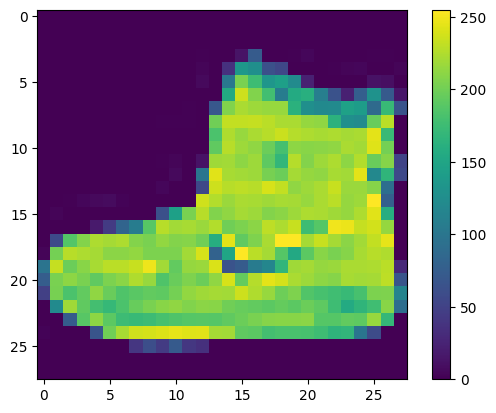

In [5]:
plt.figure()
plt.imshow(fashion_train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [7]:
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

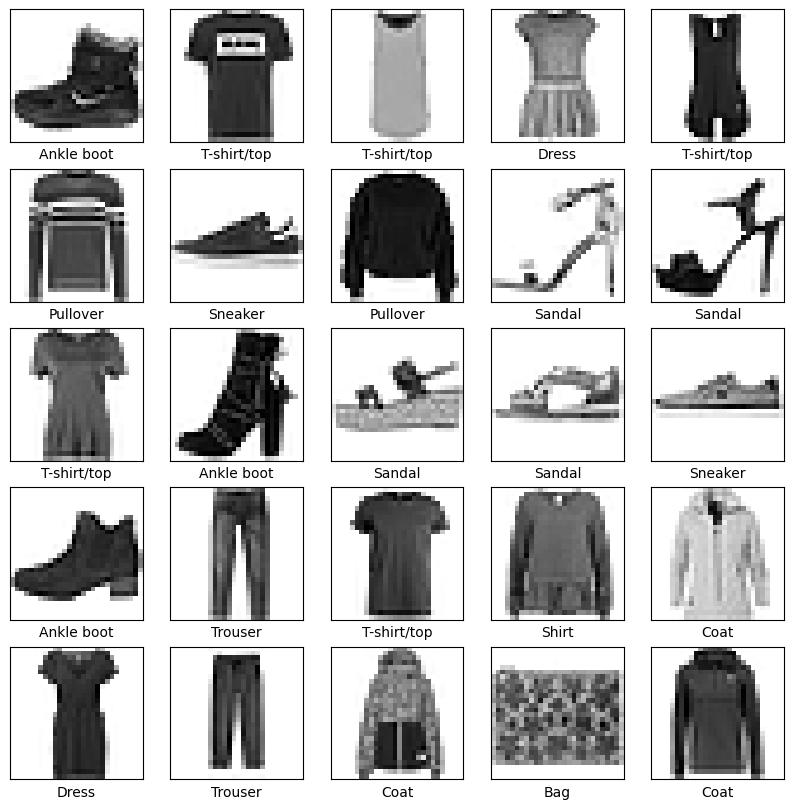

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[fashion_train_labels[i]])
plt.show()

In [8]:
batch_size = 32
num_classes = 10
epochs = 2

row_hidden = 64
col_hidden = 64

In [34]:
# Input layer
input_layer = tf.keras.Input(shape=(28, 28))

# Permute the dimensions for column-wise processing
permuted_input = tf.keras.layers.Permute((2, 1))(input_layer)

# First branch with two 1D convolutional layers followed by a bidirectional LSTM
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x1)
# x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x1)
# x1 = tf.keras.layers.LSTM(64, name='LSTM_left', use_bias=False)(x1)

# Second branch with permuted input, two 1D convolutional layers, and a bidirectional LSTM
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(permuted_input)
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x2)
# x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x2)
# x2 = tf.keras.layers.LSTM(64, name='LSTM_right', use_bias=False)(x2)

# # Concatenate the outputs of the two branches
concatenated = tf.keras.layers.Concatenate()([x1, x2])

concatenated = tf.keras.layers.GlobalMaxPooling1D(data_format=None, keepdims=False)(concatenated)

# Apply dropout
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# Output layer
output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout)

# Create the model
model_fashion_lstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_fashion_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_fashion_lstm.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 28, 28)]             0         []                            
                                                                                                  
 permute_9 (Permute)         (None, 28, 28)               0         ['input_10[0][0]']            
                                                                                                  
 conv1d_36 (Conv1D)          (None, 28, 64)               5440      ['input_10[0][0]']            
                                                                                                  
 conv1d_38 (Conv1D)          (None, 28, 64)               5440      ['permute_9[0][0]']           
                                                                                            

In [35]:
# Input layer
input_layer = tf.keras.Input(shape=(28, 28))

# Permute the dimensions for column-wise processing
permuted_input = tf.keras.layers.Permute((2, 1))(input_layer)

# First branch with two 1D convolutional layers followed by a bidirectional LSTM
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x1)
x1 = tf.keras.layers.LSTM(64, name='LSTM_left', use_bias=False)(x1)

# Second branch with permuted input, two 1D convolutional layers, and a bidirectional LSTM
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(permuted_input)
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x2)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x2)
x2 = tf.keras.layers.LSTM(64, name='LSTM_right', use_bias=False)(x2)

# Concatenate the outputs of the two branches
concatenated = tf.keras.layers.Concatenate()([x1, x2])

# Apply dropout
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# Output layer
output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout)

# Create the model
model_fashion_lstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_fashion_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_fashion_lstm.summary()

In [36]:
(fashion_train_labels).shape


(60000,)

In [37]:
model_fashion_lstm.fit(fashion_train_images, fashion_train_labels, epochs=4, batch_size=batch_size)

Epoch 1/4
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5508 - accuracy: 0.8071
Epoch 2/4
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3729 - accuracy: 0.8663
Epoch 3/4
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3333 - accuracy: 0.8796
Epoch 4/4
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3088 - accuracy: 0.8885


In [38]:
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

313/313 [==============================] - 0s 1ms/step
0.892


In [10]:
model_fashion_lstm = load_model('../model/Fashion_LSTM___Date_Time_2024_04_16__16_19_56___Loss_0.3800537884235382___Accuracy_0.8614000082015991.keras')

In [11]:
LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

original_weights_right = model_fashion_lstm.get_layer('LSTM_right').get_weights()
original_weights_left = model_fashion_lstm.get_layer('LSTM_left').get_weights()

313/313 [==============================] - 3s 7ms/step
0.8614


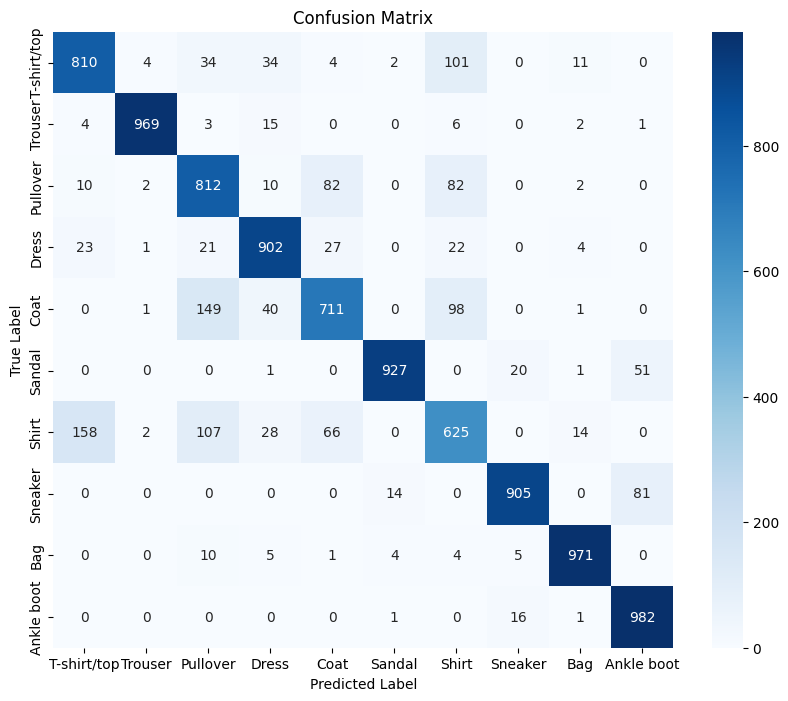

In [12]:
# Predict the classes of the test images
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

# Generate the confusion matrix
cm = confusion_matrix(fashion_test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code/main')
from iterative_approximation.Algorithm1 import *

import statistics

from iterative_approximation.Algorithm2StepPruning import *

import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [16]:
def extract_weight_array(layer):
    kernel, recurrent_kernel = layer.get_weights()

    I = np.hstack([kernel[:, :layer.units].T,recurrent_kernel[:, :layer.units].T])
    F = np.hstack([kernel[:, layer.units:2*layer.units].T,recurrent_kernel[:, layer.units:2*layer.units].T])
    O = np.hstack([kernel[:, 2*layer.units:3*layer.units].T,recurrent_kernel[:, 2*layer.units:3*layer.units].T])
    C = np.hstack([kernel[:, 3*layer.units:].T,recurrent_kernel[:, 3*layer.units:].T])
    return [I,F,O,C]


In [17]:
def set_layer_weight(layer,original_layer,weight_array):

    input_len = original_layer[0].shape[0]
    
    approximated_kernel = np.hstack([weight_array[0][:,:input_len].T,weight_array[1][:,:input_len].T,weight_array[2][:,:input_len].T,weight_array[3][:,:input_len].T])

    approximated_recurrent_kernel = np.hstack([weight_array[0][:,input_len:].T,weight_array[1][:,input_len:].T,weight_array[2][:,input_len:].T,weight_array[3][:,input_len:].T])

    approximated_weight = [approximated_kernel,approximated_recurrent_kernel]
    
    layer.set_weights(approximated_weight)


In [18]:
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy_baseline = accuracy_score(fashion_test_labels, predicted_classes)
accuracy_baseline

313/313 [==============================] - 2s 6ms/step


0.8614

In [25]:
def generate_pairs(R):
    # Define the possible values for Tc
    Tc_values = [2, 4, 8, 16, 32, 64]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = R // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64]:
                valid_pairs.append([Tc, NZc])


    # Return the list of valid pairs
    return valid_pairs

In [23]:
def generate_pairs2(C):
    # Define the possible values for Tc
    Tc_values = [2, 8, 16, 32, 64, 192]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = C // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64, 192]:
                valid_pairs.append([Tc, NZc])

    # Return the list of valid pairs
    return valid_pairs

# Example usage
C = 192
valid_pairs_C = generate_pairs2(C)
print(valid_pairs_C)

[[2, 48], [2, 56], [2, 64], [2, 72], [2, 80], [2, 88], [2, 96], [8, 12], [8, 14], [8, 16], [8, 18], [8, 20], [8, 22], [8, 24], [16, 6], [16, 7], [16, 8], [16, 9], [16, 10], [16, 11], [16, 12], [32, 3], [32, 4], [32, 5], [32, 6], [64, 2], [64, 3], [192, 1]]


In [26]:
R = 64
valid_pairs_R = generate_pairs(R)

C = 192
valid_pairs_C = generate_pairs2(C)

In [16]:
def roofline_model_baseline(clock_frequency,bandwidth,precision,N,R,C,Tr,Tc):
    Nops = N*(4*(R*C + R*(C-1)) + 24*R)

    Ncycles = max(R/Tr, C/Tc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    memory_footprint = N * 4 * (R * C) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [395]:
def roofline_model_single(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [396]:
def roofline_model_stack4(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(Nsteps*(2*NZc*Tc + 1 + 8*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [397]:
def roofline_model_group4(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000 # (Ops) / (GOps/s)

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [398]:
def roofline_model_hybrid(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000 # (Ops) / (GOps/s)

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [17]:
def design_space_exploration_baseline(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    valid_pairs_R = [2,4,8,16,32,64]
    valid_pairs_C = [2,4,8,16,32,64]

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_baseline(clock_frequency,bandwidth,32,2,R,C,pair_R,pair_C)
                        
            results.append({
                'Tr': pair_R,
                'Tc': pair_C,
                'Accuracy (%)': baseline_accuracy*100,
                'MSE': 0,
                'Nsteps': 'N/A',
                'Compressed Memory Footprint (byte)': 2*4*R*C*4,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })

    result = pd.DataFrame(results)

    return result


In [400]:
def design_space_exploration_single(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
    model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
    LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

    # cross gate: right LSTM
    # cross gate: left LSTM
    W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
    WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
            W2 = WeightArrayStepPruning(WW, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1.iterative_approximation_step1()
                W2.iterative_approximation_step1()

                # Recalculate MSE for the new weights
                W_MSE = (W1.average_mse_array() + W2.average_mse_array()) / 2

                if W1.steps > 30:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_right_layer,original_weights_right,W1.current_reconstructed_weight_array)
                    set_layer_weight(LSTM_left_layer,original_weights_left,W2.current_reconstructed_weight_array)
                    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
                    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_single(clock_frequency,bandwidth,W1.precision,2,64,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed+W2.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': ((W1.average_mse_array() + W2.average_mse_array())/2),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed+W2.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
            model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    result = pd.DataFrame(results)

    return result


In [58]:
def design_space_exploration_stack4(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
    model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
    LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

    # cross gate: right LSTM
    # cross gate: left LSTM
    W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
    WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'weight', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
            W2 = WeightArrayStepPruning(WW, 'weight', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1_approximated = W1.iterative_approximation_step3_norm('spec')
                W2_approximated = W2.iterative_approximation_step3_norm('spec')

                # Recalculate MSE for the new weights
                W_MSE = (W1.average_mse_weight() + W2.average_mse_weight()) / 2

                if W1.steps > 40:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
                    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)
                    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
                    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_stack4(clock_frequency,bandwidth,W1.precision,2,64,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed+W2.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': ((W1.average_mse_weight() + W2.average_mse_weight()) / 2),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed+W2.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
            model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    result = pd.DataFrame(results)

    return result


In [57]:
def design_space_exploration_group4(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
    model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
    LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

    # cross gate: right LSTM
    # cross gate: left LSTM
    W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
    WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
            W2 = WeightArrayStepPruning(WW, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1.iterative_approximation_step2()
                W2.iterative_approximation_step2()

                # Recalculate MSE for the new weights
                W_MSE = (W1.average_mse_array() + W2.average_mse_array()) / 2

                if W1.steps > 40:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_right_layer,original_weights_right,W1.current_reconstructed_weight_array)
                    set_layer_weight(LSTM_left_layer,original_weights_left,W2.current_reconstructed_weight_array)
                    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
                    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_group4(clock_frequency,bandwidth,W1.precision,2,64,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed+W2.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': ((W1.average_mse_array() + W2.average_mse_array())/2),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed+W2.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
            model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    result = pd.DataFrame(results)

    return result


In [377]:
def design_space_exploration_hybrid(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth,strategy,norm):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
    model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
    LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

    # cross gate: right LSTM
    # cross gate: left LSTM
    W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
    WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
            W2 = WeightArrayStepPruning(WW, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1.hybrid_iterative_approximation_step_norm(strategy,norm)
                W2.hybrid_iterative_approximation_step_norm(strategy,norm)

                # Recalculate MSE for the new weights
                W_MSE = (W1.average_mse_array() + W2.average_mse_array()) / 2

                if W1.steps > 40:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_right_layer,original_weights_right,W1.current_reconstructed_weight_array)
                    set_layer_weight(LSTM_left_layer,original_weights_left,W2.current_reconstructed_weight_array)
                    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
                    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_hybrid(clock_frequency,bandwidth,W1.precision,2,64,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed+W2.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': ((W1.average_mse_array() + W2.average_mse_array())/2),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed+W2.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
            model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    result = pd.DataFrame(results)

    return result


In [20]:
accuracy_baseline=0.8614

In [465]:
clock_frequency = 150 # 400MHz
bandwidth = 10 # 10GB/s

In [385]:
baseline_10GB = design_space_exploration_baseline(accuracy_baseline,0.01,0.005, clock_frequency, bandwidth)

In [386]:
baseline_10GB

,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s)
0,2,2,86.14,0,N/A,393216,199168,224.0,0.503234,177.828571,5.032342,0.00004
1,2,4,86.14,0,N/A,393216,199168,224.0,0.503234,177.828571,5.032342,0.00004
2,2,8,86.14,0,N/A,393216,199168,224.0,0.503234,177.828571,5.032342,0.00004
3,2,16,86.14,0,N/A,393216,199168,224.0,0.503234,177.828571,5.032342,0.00004
4,2,32,86.14,0,N/A,393216,199168,224.0,0.503234,177.828571,5.032342,0.00004
5,2,64,86.14,0,N/A,393216,199168,224.0,0.503234,177.828571,5.032342,0.00004
6,4,2,86.14,0,N/A,393216,199168,112.0,0.503234,355.657143,5.032342,0.00004
7,4,4,86.14,0,N/A,393216,199168,112.0,0.503234,355.657143,5.032342,0.00004
8,4,8,86.14,0,N/A,393216,199168,112.0,0.503234,355.657143,5.032342,0.00004
9,4,16,86.14,0,N/A,393216,199168,112.0,0.503234,355.657143,5.032342,0.00004


In [373]:
single_10GB = design_space_exploration_single(accuracy_baseline,0.01,0.005, clock_frequency, bandwidth)

313/313 [==============================] - 2s 6ms/step


KeyboardInterrupt: 

In [79]:
stack4_10GB = design_space_exploration_stack4(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth)

313/313 [==============================] - 2s 6ms/step


In [80]:
stack4_10GB.to_csv('dse_result/stack4_10GB.csv', index=False)

In [81]:
group4_10GB = design_space_exploration_group4(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth)

313/313 [==============================] - 2s 6ms/step


In [82]:
group4_10GB.to_csv('dse_result/group4_10GB.csv', index=False)

In [83]:
hybrid1_10GB = design_space_exploration_hybrid(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth,1,'spec')

313/313 [==============================] - 2s 7ms/step


In [84]:
hybrid1_10GB.to_csv('dse_result/hybrid1_10GB.csv', index=False)

In [86]:
hybrid3_10GB = design_space_exploration_hybrid(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth,3,'fro')

313/313 [==============================] - 2s 6ms/step


In [87]:
hybrid3_10GB.to_csv('dse_result/hybrid3_10GB.csv', index=False)

In [88]:
hybrid6_10GB = design_space_exploration_hybrid(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth,6,'spec')

KeyboardInterrupt: 

In [ ]:
hybrid6_10GB.to_csv('dse_result/hybrid6_10GB.csv', index=False)

In [330]:
single_10GB = pd.read_csv('../dse_result/single_10GB.csv')
stack4_10GB = pd.read_csv('../dse_result/stack4_10GB.csv')
group4_10GB = pd.read_csv('../dse_result/group4_10GB.csv')
hybrid1_10GB = pd.read_csv('../dse_result/hybrid1_10GB.csv')
hybrid3_10GB = pd.read_csv('../dse_result/hybrid3_10GB.csv')

In [29]:
def update_results(df, clock_frequency, bandwidth, computation_roof):
    # Define a helper function to apply to each row
    def update_row(row):
        # Calculate CP (Clock Performance)
        row['CP (GOps/s)'] = (row['Nops'] / row['Ncycles']) * clock_frequency/1000
        
        # Calculate Attainable Performance (AttPerf)
        row['AttPerf (GOps/s)'] = min(row['CTC (Ops/byte)'] * bandwidth, row['CP (GOps/s)'],computation_roof)
        
        # Calculate Execution Time (Texe)
        if row['AttPerf (GOps/s)'] != 0:  # Avoid division by zero
            row['Execution Time (s)'] = row['Nops'] / row['AttPerf (GOps/s)']/1000000000
        else:
            row['Execution Time (s)'] = float('inf')  # Handle division by zero as infinite time
        
        return row

    # Apply the function across the DataFrame
    df = df.apply(update_row, axis=1)
    return df

In [409]:
import pandas as pd
from math import ceil, log2

def cal_dsp_usage_baseline(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr']) +
                           adder_dsp * (result['Tc'] - 1)*result['Tr'] +
                           multiplier_dsp * result['Tc'] *result['Tr']) * 4 * 2
    return result

In [385]:
def cal_dsp_usage(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * 2 * result['Tc']) * 4 * 2

    return result

In [935]:
def cal_dsp_usage_stack4(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0

    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * 2 * result['Tc']) * 2
    
    result['Simulated Ncycles'] = (result['Nsteps'] - 1) * max(result['NZr'], result['NZc']) + 3 + ceil(log2(result['Tc'])) + 64 * 4 / result['Tr']
    return result

In [329]:
def remove(df, accuracy_baseline, accuracy_loss, DSP_max, MSE_threshold):
    result = df.copy()

    # Calculate the accuracy threshold
    accuracy = accuracy_baseline*100 - accuracy_loss
    
    # Remove entries from the DataFrame where 'Accuracy (%)' is not greater than the calculated accuracy
    result = result[result['Accuracy (%)'] > accuracy]

    result = result[result['DSP Usage'] < DSP_max]

    result = result[result['MSE'] < MSE_threshold]
    
    return result

In [328]:
def remove1(df, accuracy_baseline, accuracy_loss, DSP_max, MSE_threshold):
    result = df.copy()

    # Calculate the accuracy threshold
    accuracy = accuracy_baseline*100 - accuracy_loss
    
    # Remove entries from the DataFrame where 'Accuracy (%)' is not greater than the calculated accuracy
    result = result[result['Accuracy (%)'] > accuracy]

    result = result[result['DSP Usage'] < DSP_max]

    result = result[result['MSE'] < MSE_threshold]
    result = result[result['Accuracy (%)'] < (accuracy_baseline*100 -0.25)]
    
    
    return result

In [31]:
R=64
C=192

In [32]:
def correct_baseline(df, clock_frequency, bandwidth ,adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Nops = N*(4*(R*C + R*(C-1)) + 24*R)
    result['Nops'] = 2*(4*(R*C + R*(C-1)))
    # Compute the 'Ncycles' by using pandas methods that work with Series
    # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    term1 = R/result['Tr']
    term2 = C/result['Tc']
    # term3 = 7 * 64 / result['Tr']
    result['Ncycles'] = term1 * term2
    inout = 2*(C+2*R)*4
    result['CTC (Ops/byte)'] = result['Nops']/(inout + result['Compressed Memory Footprint (byte)'])
    
    # Compute 'CP (GOps/s)'
    result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    term1 = result['CP (GOps/s)']
    term2 = result['CTC (Ops/byte)'] * bandwidth
    result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000
    
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0

    if 'Simulated Execution Time (s)' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Execution Time (s)'] = 0

    if 'BRAM Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['BRAM Usage'] = 0
        
    result['BRAM Usage'] = 2*(1+1)

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr']) +
                           adder_dsp * (result['Tc'] - 1)*result['Tr'] +
                           multiplier_dsp * result['Tc'] *result['Tr']) * 4 * 2
    
    # Ensure the computation of 'Simulated Ncycles' is done element-wise
    result['Simulated Ncycles'] = result['Ncycles'] + 3 + result['Tc'].apply(lambda x: ceil(log2(x))) + R / result['Tr']

    result['Simulated Execution Time (s)'] = result['Simulated Ncycles']/(clock_frequency*1000000)
    
    return result

In [439]:
def correct_single(df, clock_frequency, bandwidth ,adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)
    result['Nops'] = 2*(4*result['Nsteps']*(2*result['NZc']*result['Tc'] + 2*result['NZr']*result['Tr']))
    # Compute the 'Ncycles' by using pandas methods that work with Series
    # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    term1 = result['Nsteps'] * result['NZr']
    term2 = result['Nsteps'] * result['NZc']
    # term3 = 7 * 64 / result['Tr']
    result['Ncycles'] = pd.concat([term1, term2], axis=1).max(axis=1)

    inout = 2*(C+2*R)*4
    result['CTC (Ops/byte)'] = result['Nops']/(inout + result['Compressed Memory Footprint (byte)'])
    
    # Compute 'CP (GOps/s)'
    result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    term1 = result['CP (GOps/s)']
    term2 = result['CTC (Ops/byte)'] * bandwidth
    result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000
    
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0

    if 'Simulated Execution Time (s)' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Execution Time (s)'] = 0

    if 'BRAM Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['BRAM Usage'] = 0
        
    result['BRAM Usage'] = 2*(4*result['Tr']+4*result['Tc'])

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * result['Tc'] + multiplier_dsp * result['Tr']) * 4 * 2
    
    result['Simulated Ncycles'] = (result['Nsteps'] - 1) * (result[['NZr', 'NZc']].max(axis=1) + 1) + 3 + result['Tc'].apply(lambda x: ceil(log2(x))) + result['NZr'] + result['NZc'] #+ R / result['Tr']

    result['Simulated Execution Time (s)'] = result['Simulated Ncycles']/(clock_frequency*1000000)
    
    return result

In [438]:
def correct_stack4(df, clock_frequency,bandwidth,adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # N*(Nsteps*(2*NZc*Tc + 1 + 8*NZr*Tr) + 24*R)
    result['Nops'] = 2*(result['Nsteps']*(2*result['NZc']*result['Tc'] + 8*result['NZr']*result['Tr']))
    # Compute the 'Ncycles' by using pandas methods that work with Series
    # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    term1 = 4 * result['Nsteps'] * result['NZr']
    term2 = result['Nsteps'] * result['NZc']
    # term3 = 7 * 64 / result['Tr']
    result['Ncycles'] = pd.concat([term1, term2], axis=1).max(axis=1)

    inout = 2*(C+2*R)*4
    result['CTC (Ops/byte)'] = result['Nops']/(inout + result['Compressed Memory Footprint (byte)'])
    
    # Compute 'CP (GOps/s)'
    result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    term1 = result['CP (GOps/s)']
    term2 = result['CTC (Ops/byte)'] * bandwidth
    result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000
    
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0

    if 'Simulated Execution Time (s)' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Execution Time (s)'] = 0

    if 'BRAM Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['BRAM Usage'] = 0
        
    result['BRAM Usage'] = 2*(result['Tr']+result['Tc'])

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) + 
                           multiplier_dsp * result['Tc'] + multiplier_dsp * result['Tr']) * 2
    
    result['Simulated Ncycles'] = (result['Nsteps'] - 1) * (result[['NZr', 'NZc']].apply(lambda x: max(4*x['NZr'], x['NZc']), axis=1) + 1) + 3 + result['Tc'].apply(lambda x: ceil(log2(x))) + result['NZr'] + result['NZc'] #+ R * 4 / result['Tr']
    
    result['Simulated Execution Time (s)'] = result['Simulated Ncycles']/(clock_frequency*1000000)
    return result

In [440]:
def correct_group4(df, clock_frequency,bandwidth,adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)
    result['Nops'] = 2*(result['Nsteps']*(8*result['NZc']*result['Tc'] + 4 + 8*result['NZr']*result['Tr']))
    # Compute the 'Ncycles' by using pandas methods that work with Series
    # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    term1 = result['Nsteps'] * result['NZr']
    term2 = result['Nsteps'] * result['NZc']
    result['Ncycles'] = pd.concat([term1, term2], axis=1).max(axis=1)

    inout = 2*(C+2*R)*4
    result['CTC (Ops/byte)'] = result['Nops']/(inout + result['Compressed Memory Footprint (byte)'])
    
    # Compute 'CP (GOps/s)'
    result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    term1 = result['CP (GOps/s)']
    term2 = result['CTC (Ops/byte)'] * bandwidth
    result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000

    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    if 'BRAM Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['BRAM Usage'] = 0

    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0
        
    if 'Simulated Execution Time (s)' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Execution Time (s)'] = 0

    if 'BRAM Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['BRAM Usage'] = 0
        
    result['BRAM Usage'] = 2*(4*result['Tr']+result['Tc'])

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'])*4 +
                           adder_dsp * (result['Tc']) + multiplier_dsp * 4 + 
                           multiplier_dsp * result['Tc'] + multiplier_dsp * result['Tr']*4) * 2

    result['BRAM Usage'] = 2*(4*result['Tr']+result['Tc'])

    result['Simulated Ncycles'] = (result['Nsteps'] - 1) * (result[['NZr', 'NZc']].max(axis=1) + 1) + 3 + result['Tc'].apply(lambda x: ceil(log2(x))) + result['NZr'] + result['NZc'] #+ R / result['Tr']

    result['Simulated Execution Time (s)'] = result['Simulated Ncycles']/(clock_frequency*1000000)

    return result

In [436]:
def correct_hybrid(df, clock_frequency, bandwidth ,adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)
    result['Nops'] = 2*(4*result['Nsteps']*(2*result['NZc']*result['Tc'] + 1 + 2*result['NZr']*result['Tr']))
    # Compute the 'Ncycles' by using pandas methods that work with Series
    # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    term1 = result['Nsteps'] * result['NZr']
    term2 = result['Nsteps'] * result['NZc']
    # term3 = 7 * 64 / result['Tr']
    result['Ncycles'] = pd.concat([term1, term2], axis=1).max(axis=1)
    
    inout = 2*(C+2*R)*4
    result['CTC (Ops/byte)'] = result['Nops']/(inout + result['Compressed Memory Footprint (byte)'])
    
    # Compute 'CP (GOps/s)'
    result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    term1 = result['CP (GOps/s)']
    term2 = result['CTC (Ops/byte)'] * bandwidth
    result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000
    
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0
        
    if 'Simulated Ncycles' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Ncycles'] = 0
        
    if 'Simulated Execution Time (s)' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['Simulated Execution Time (s)'] = 0

    if 'BRAM Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['BRAM Usage'] = 0
    
    result['BRAM Usage'] = 2*(4*result['Tr']+4*result['Tc'])

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * result['Tc'] + multiplier_dsp * result['Tr']) * 4 * 2

    result['Simulated Ncycles'] = (result['Nsteps'] - 1) * (result[['NZr', 'NZc']].max(axis=1) + 1) + 3 + result['Tc'].apply(lambda x: ceil(log2(x))) + result['NZr'] + result['NZc'] #+ R / result['Tr']

    
    result['Simulated Execution Time (s)'] = result['Simulated Ncycles']/(clock_frequency*1000000)
    return result

In [467]:
clock_frequency = 150
bandwidth = 10

In [468]:
baseline_10GB_dsp = correct_baseline(baseline_10GB,clock_frequency,bandwidth,1,4,1)
single_10GB_dsp = correct_single(single_10GB,clock_frequency,bandwidth,1,4,1)
stack4_10GB_dsp = correct_stack4(stack4_10GB,clock_frequency,bandwidth,1,4,1)
group4_10GB_dsp = correct_group4(group4_10GB,clock_frequency,bandwidth,1,4,1)
hybrid1_10GB_dsp = correct_hybrid(hybrid1_10GB,clock_frequency,bandwidth,1,4,1)
hybrid3_10GB_dsp = correct_hybrid(hybrid3_10GB,clock_frequency,bandwidth,1,4,1)
# remove entries that do not satisfy accuracy requirement
baseline_10GB_dsp = remove(baseline_10GB_dsp, accuracy_baseline,1,1700,0.006)
xf = remove(single_10GB_dsp, accuracy_baseline,1,1700,0.006)
stack4_10GB_dsp = remove1(stack4_10GB_dsp, accuracy_baseline,1,1700,0.006)
group4_10GB_dsp = remove(group4_10GB_dsp, accuracy_baseline,1,1700,0.006)
hybrid1_10GB_dsp = remove(hybrid1_10GB_dsp, accuracy_baseline,1,1700,0.006)
hybrid3_10GB_dsp = remove(hybrid3_10GB_dsp, accuracy_baseline,1,1700,0.006)

single_10GB_dsp.to_csv('../dse_result/single_10GB_dsp.csv', index=False)
stack4_10GB_dsp.to_csv('../dse_result/stack4_10GB_dsp.csv', index=False)
group4_10GB_dsp.to_csv('../dse_result/group4_10GB_dsp.csv', index=False)
hybrid1_10GB_dsp.to_csv('../dse_result/hybrid1_10GB_dsp.csv', index=False)
hybrid3_10GB_dsp.to_csv('../dse_result/hybrid3_10GB_dsp.csv', index=False)


In [392]:
baseline_10GB_dsp

,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
0,2,2,86.14,0,N/A,393216,196096,3072.0,0.495472,12.766667,4.954722,0.00004,160,3108.0,0.000016,4


In [76]:
single_10GB_dsp

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
0,16,48,2,2,85.22,0.005451,12,51072.0,24576,576,0.458234,8.533333,4.582339,0.000005,160,607,3.035000e-06,24
1,16,56,2,2,85.23,0.005403,11,52448.0,25344,616,0.460733,8.228571,4.607330,0.000006,160,646,3.230000e-06,24
2,16,64,2,2,85.17,0.004771,14,73920.0,35840,896,0.468619,8.000000,4.686192,0.000008,160,929,4.645000e-06,24
3,16,72,2,2,85.21,0.005143,11,63712.0,30976,792,0.467407,7.822222,4.674070,0.000007,160,822,4.110000e-06,24
4,16,80,2,2,85.15,0.005457,9,56736.0,27648,720,0.466271,7.680000,4.662709,0.000006,160,748,3.740000e-06,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,8,16,8,8,85.57,0.005553,8,49664.0,24576,128,0.470588,38.400000,4.705882,0.000005,640,149,7.450000e-07,72
234,8,18,8,8,85.32,0.005890,6,40320.0,19968,108,0.465672,36.977778,4.656716,0.000004,640,127,6.350000e-07,72
235,8,20,8,8,85.35,0.005745,6,43392.0,21504,120,0.467967,35.840000,4.679666,0.000005,640,139,6.950000e-07,72
236,8,22,8,8,85.45,0.005631,6,46464.0,23040,132,0.469974,34.909091,4.699739,0.000005,640,151,7.550000e-07,72


In [78]:
stack4_10GB_dsp

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
0,16,48,2,2,86.22,0.005979,14,25984.0,12544,896,0.439462,2.800000,2.800000,0.000004,40,913,0.000005,6
1,16,56,2,2,85.94,0.005935,13,25792.0,12480,832,0.440181,3.000000,3.000000,0.000004,40,856,0.000004,6
2,16,64,2,2,86.14,0.005915,12,25344.0,12288,768,0.440367,3.200000,3.200000,0.000004,40,799,0.000004,6
3,16,72,2,2,85.75,0.005954,11,24640.0,11968,792,0.440000,3.022222,3.022222,0.000004,40,822,0.000004,6
4,16,80,2,2,85.94,0.005898,11,26048.0,12672,880,0.442953,2.880000,2.880000,0.000004,40,910,0.000005,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,1,64,64,2,85.48,0.005739,9,27945.0,13824,576,0.453172,4.800000,4.531716,0.000003,660,589,0.000003,130
395,1,72,64,2,85.53,0.005650,9,29097.0,14400,648,0.454876,4.444444,4.444444,0.000003,660,661,0.000003,130
396,1,80,64,2,85.64,0.005586,9,30249.0,14976,720,0.456460,4.160000,4.160000,0.000004,660,733,0.000004,130
397,1,88,64,2,85.55,0.005547,9,31401.0,15552,792,0.457937,3.927273,3.927273,0.000004,660,805,0.000004,130


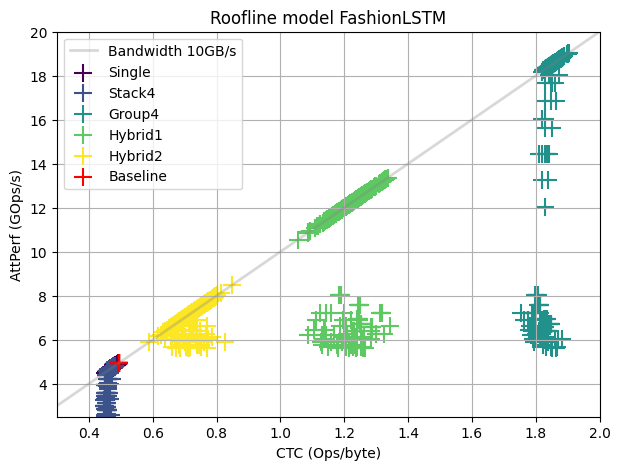

In [469]:
# Plotting
plt.figure(figsize=(7, 5))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Bandwidth 10GB/s',color='gray',alpha=0.3, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=170, label='Single')

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=170, label='Stack4')

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=170, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=170, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=170, label='Hybrid2')

plt.scatter(baseline_10GB_dsp['CTC (Ops/byte)'], baseline_10GB_dsp['AttPerf (GOps/s)'],
            color='red', marker='+', s=170, label='Baseline')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
plt.xlim([0.3,2])
plt.ylim([2.5,20])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.grid()
plt.title('Roofline model FashionLSTM')

# Show the plot
plt.show()

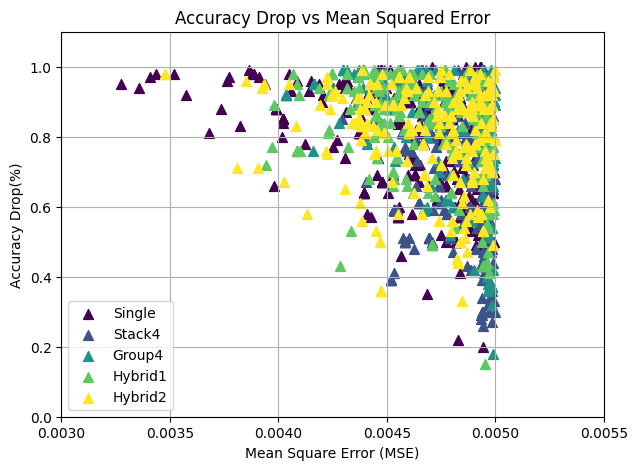

In [327]:
# Assuming you've already imported or defined stack4_10GB and single_10GB

# Plotting
plt.figure(figsize=(7, 5))


plt.scatter(single_10GB_dsp['MSE']-0.001,accuracy_baseline*100 - single_10GB_dsp['Accuracy (%)'],
            color=colors[0], marker='^', s=50, label='Single')

plt.scatter(stack4_10GB_dsp['MSE']-0.001,accuracy_baseline*100 - stack4_10GB_dsp['Accuracy (%)'],
            color=colors[1], marker='^', s=50, label='Stack4')

plt.scatter(group4_10GB_dsp['MSE']-0.001, accuracy_baseline*100 - group4_10GB_dsp['Accuracy (%)'],
            color=colors[2], marker='^', s=50, label='Group4')

plt.scatter(hybrid1_10GB_dsp['MSE']-0.001, accuracy_baseline*100 - hybrid1_10GB_dsp['Accuracy (%)'],
            color=colors[3], marker='^', s=50, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['MSE']-0.001, accuracy_baseline*100 - hybrid3_10GB_dsp['Accuracy (%)'],
            color=colors[4], marker='^', s=50, label='Hybrid2')



# Labeling the axes
plt.title('Accuracy Drop vs Mean Squared Error')
plt.xlabel('Mean Square Error (MSE)')
plt.ylabel('Accuracy Drop(%)')
plt.xlim([0.003,0.0055])
plt.ylim([0,1.1])

# Add a legend
plt.legend()

plt.grid()



# Show the plot
plt.show()

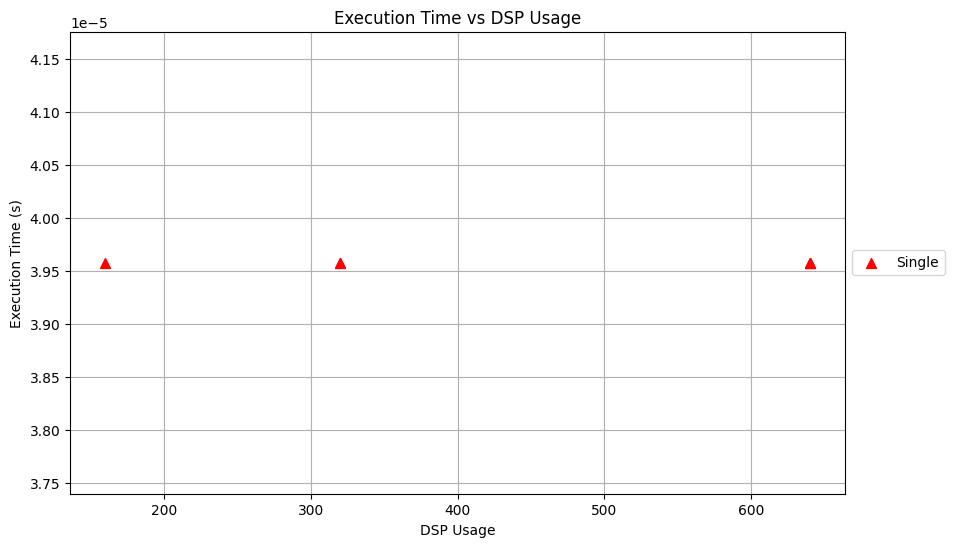

In [263]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(baseline_10GB_dsp['DSP Usage'], baseline_10GB_dsp['Execution Time (s)'],
            color='red', marker='^', s=50, label='Single')


# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim([0,12000])
# plt.ylim([0.0000394,0.0000398])

plt.grid()

# Show the plot
plt.show()

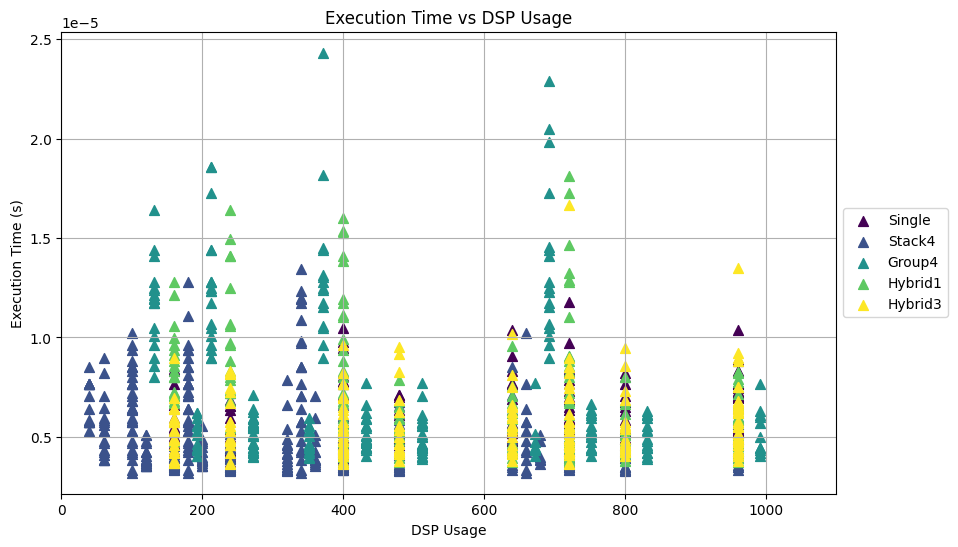

In [460]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['DSP Usage'], single_10GB_dsp['Execution Time (s)'],
            color=colors[0], marker='^', s=50, label='Single')

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=50, label='Stack4')

plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['Execution Time (s)'],
            color=colors[2], marker='^', s=50, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['DSP Usage'], hybrid1_10GB_dsp['Execution Time (s)'],
            color=colors[3], marker='^', s=50, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['DSP Usage'], hybrid3_10GB_dsp['Execution Time (s)'],
            color=colors[4], marker='^', s=50, label='Hybrid3')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([0,1100])
plt.grid()

# Show the plot
plt.show()

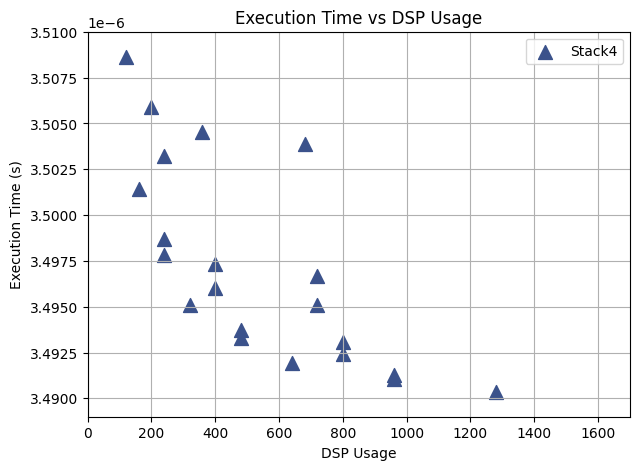

In [369]:
# Plotting
plt.figure(figsize=(7, 5))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

df_stack4 = stack4_10GB_dsp[stack4_10GB_dsp['Nops'] == 16128]

plt.scatter(df_stack4['DSP Usage'], df_stack4['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4')

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend()

plt.grid()
plt.ylim([0.000003489,0.00000351])
plt.xlim([0,1700])
# Show the plot
plt.show()

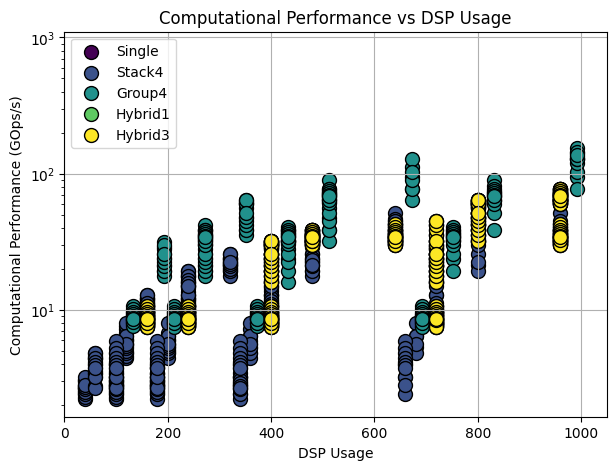

In [356]:
# Plotting
plt.figure(figsize=(7, 5))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['DSP Usage'], single_10GB_dsp['CP (GOps/s)'],
            color=colors[0], marker='o',edgecolors='black', s=100, label='Single')

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['CP (GOps/s)'],
            color=colors[1], marker='o',edgecolors='black', s=100, label='Stack4')

plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['CP (GOps/s)'],
            color=colors[2], marker='o',edgecolors='black', s=100, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['DSP Usage'], hybrid1_10GB_dsp['CP (GOps/s)'],
            color=colors[3], marker='o',edgecolors='black', s=100, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['DSP Usage'], hybrid3_10GB_dsp['CP (GOps/s)'],
            color=colors[4], marker='o',edgecolors='black', s=100, label='Hybrid3')
            

# Labeling the axes
plt.title('Computational Performance vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Computational Performance (GOps/s)')

# Set y-axis to log scale
plt.yscale('log')

# Add a legend
plt.legend(loc='upper left')

plt.grid()
plt.xlim([0,1050])

# Show the plot
plt.show()

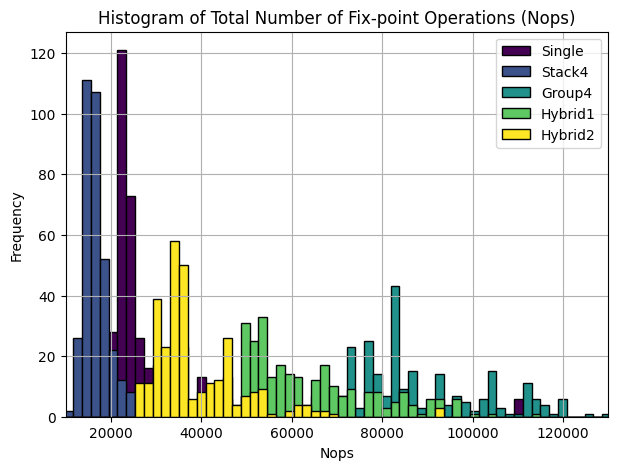

In [347]:
# Plotting the histogram
plt.figure(figsize=(7,5))  # Set the figure size

colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Determine the maximum value among all datasets to set a reasonable bin size
max_value = max(
    single_10GB_dsp['Nops'].max(),
    stack4_10GB_dsp['Nops'].max(),
    group4_10GB_dsp['Nops'].max(),
    hybrid1_10GB_dsp['Nops'].max(),
    hybrid3_10GB_dsp['Nops'].max()
)

# Calculate a reasonable bin size based on the maximum value
bin_size = max_value / 75  # Adjust 30 to the desired number of bins

plt.hist(single_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[0], edgecolor='black',label='Single')
plt.hist(stack4_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[1], edgecolor='black',label='Stack4')
plt.hist(group4_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[2], edgecolor='black',label='Group4')
plt.hist(hybrid1_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[3], edgecolor='black',label='Hybrid1')
plt.hist(hybrid3_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[4], edgecolor='black',label='Hybrid2')

plt.xlabel('Nops')
plt.ylabel('Frequency')
plt.title('Histogram of Total Number of Fix-point Operations (Nops)')

# Show the grid
plt.grid(True)
plt.xlim([10000,130000])
plt.legend()

# Display the plot
plt.show()

In [51]:
print(f"Single Nops Median: {single_10GB_dsp['Nops'].median()}")
print(f"Stack4 Nops Median: {stack4_10GB_dsp['Nops'].median()}")
print(f"Group4 Nops Median: {group4_10GB_dsp['Nops'].median()}")
print(f"Hybrid1 Nops Median: {hybrid1_10GB_dsp['Nops'].median()}")
print(f"Hybrid3 Nops Median: {hybrid3_10GB_dsp['Nops'].median()}")

Single Nops Median: 23296.0
Stack4 Nops Median: 16128.0
Group4 Nops Median: 83160.0
Hybrid1 Nops Median: 57720.0
Hybrid3 Nops Median: 34632.0


In [52]:
print(f"Single AttPerf (GOps/s) Median: {single_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Stack4 AttPerf (GOps/s) Median: {stack4_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Group4 AttPerf (GOps/s) Median: {group4_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Hybrid1 AttPerf (GOps/s) Median: {hybrid1_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Hybrid3 AttPerf (GOps/s) Median: {hybrid3_10GB_dsp['AttPerf (GOps/s)'].median()}")

Single AttPerf (GOps/s) Median: 4.674070497344278
Stack4 AttPerf (GOps/s) Median: 4.581243973303678
Group4 AttPerf (GOps/s) Median: 18.33588565594691
Hybrid1 AttPerf (GOps/s) Median: 10.7
Hybrid3 AttPerf (GOps/s) Median: 6.976385804287721


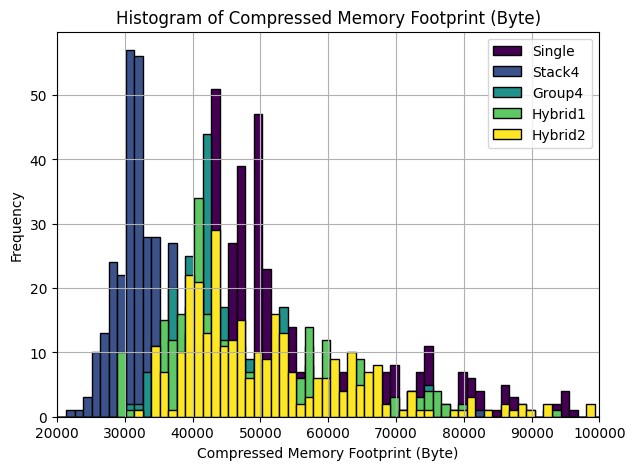

In [348]:
# Plotting the histogram
plt.figure(figsize=(7,5))  # Set the figure size

colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Determine the maximum value among all datasets to set a reasonable bin size
max_value = max(
    single_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    stack4_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    group4_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    hybrid1_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    hybrid3_10GB_dsp['Compressed Memory Footprint (byte)'].max()
)

# Calculate a reasonable bin size based on the maximum value
bin_size = max_value / 180  # Adjust 30 to the desired number of bins

plt.hist(single_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[0], edgecolor='black',label='Single')
plt.hist(stack4_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[1], edgecolor='black',label='Stack4')
plt.hist(group4_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[2], edgecolor='black',label='Group4')
plt.hist(hybrid1_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[3], edgecolor='black',label='Hybrid1')
plt.hist(hybrid3_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[4], edgecolor='black',label='Hybrid2')

# Adding labels and title
plt.xlabel('Compressed Memory Footprint (Byte)')
plt.ylabel('Frequency')
plt.title('Histogram of Compressed Memory Footprint (Byte)')

# Show the grid
plt.grid(True)
plt.xlim([20000,100000])
plt.legend()

# Display the plot
plt.show()

,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage


In [462]:
baseline_10GB_min = baseline_10GB_dsp[baseline_10GB_dsp['Execution Time (s)'] == baseline_10GB_dsp['Execution Time (s)'].min()]
single_10GB_min = single_10GB_dsp[single_10GB_dsp['Execution Time (s)'] == single_10GB_dsp['Execution Time (s)'].min()]
stack4_10GB_min = stack4_10GB_dsp[stack4_10GB_dsp['Execution Time (s)'] == stack4_10GB_dsp['Execution Time (s)'].min()]
group4_10GB_min = group4_10GB_dsp[group4_10GB_dsp['Execution Time (s)'] == group4_10GB_dsp['Execution Time (s)'].min()]
hybrid1_10GB_min = hybrid1_10GB_dsp[hybrid1_10GB_dsp['Execution Time (s)'] == hybrid1_10GB_dsp['Execution Time (s)'].min()]
hybrid3_10GB_min = hybrid3_10GB_dsp[hybrid3_10GB_dsp['Execution Time (s)'] == hybrid3_10GB_dsp['Execution Time (s)'].min()]


In [397]:
baseline_10GB_min.iloc[0]

Tr                                            2
Tc                                            2
Accuracy (%)                              86.14
MSE                                           0
Nsteps                                      N/A
Compressed Memory Footprint (byte)       393216
Nops                                     196096
Ncycles                                  3072.0
CTC (Ops/byte)                         0.495472
CP (GOps/s)                           12.766667
AttPerf (GOps/s)                       4.954722
Execution Time (s)                      0.00004
DSP Usage                                   160
Simulated Ncycles                        3108.0
Simulated Execution Time (s)           0.000016
BRAM Usage                                    4
Name: 0, dtype: object

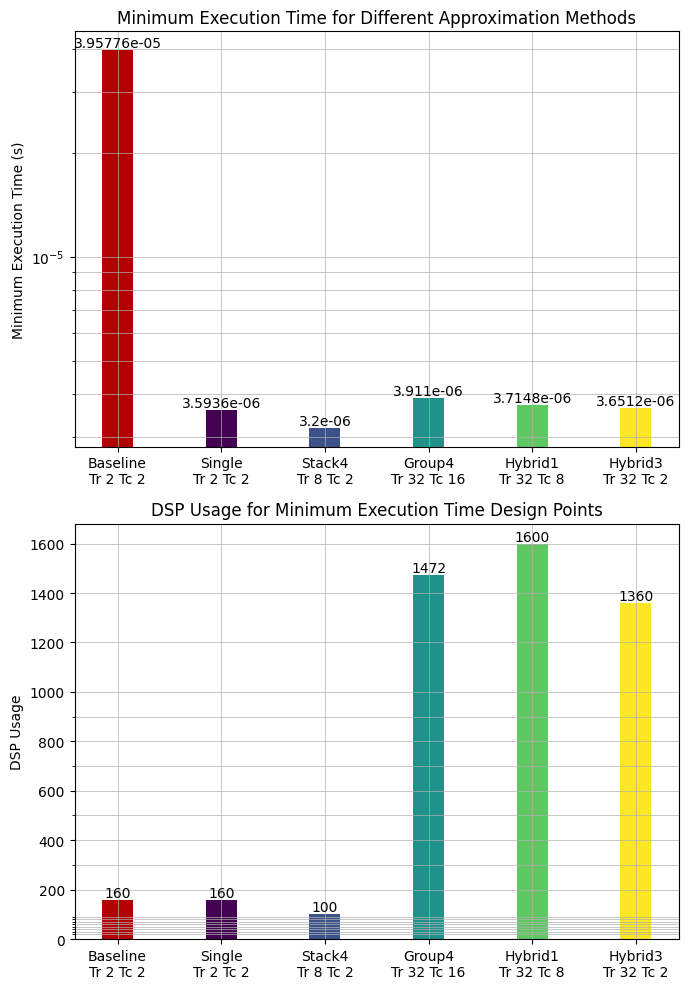

In [470]:
import matplotlib.ticker as ticker

# Prepare the DataFrame for Minimum Execution Time
df_min_values_time = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_10GB_min['Tr'].iloc[0]} Tc {baseline_10GB_min['Tc'].iloc[0]}",
        f"Single\nTr {single_10GB_min['Tr'].iloc[0]} Tc {single_10GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_10GB_min['Tr'].iloc[0]} Tc {stack4_10GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_10GB_min['Tr'].iloc[0]} Tc {group4_10GB_min['Tc'].iloc[0]}",
        f"Hybrid1\nTr {hybrid1_10GB_min['Tr'].iloc[0]} Tc {hybrid1_10GB_min['Tc'].iloc[0]}",
        f"Hybrid3\nTr {hybrid3_10GB_min['Tr'].iloc[0]} Tc {hybrid3_10GB_min['Tc'].iloc[0]}"
    ],
    'Min Execution Time (s)': [
        baseline_10GB_min['Execution Time (s)'].iloc[0],
        single_10GB_min['Execution Time (s)'].iloc[0],
        stack4_10GB_min['Execution Time (s)'].iloc[0],
        group4_10GB_min['Execution Time (s)'].iloc[0],
        hybrid1_10GB_min['Execution Time (s)'].iloc[0],
        hybrid3_10GB_min['Execution Time (s)'].iloc[0]
    ]
})

# Prepare the DataFrame for DSP Usage
df_min_values_dsp = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_10GB_min['Tr'].iloc[0]} Tc {baseline_10GB_min['Tc'].iloc[0]}",
        f"Single\nTr {single_10GB_min['Tr'].iloc[0]} Tc {single_10GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_10GB_min['Tr'].iloc[0]} Tc {stack4_10GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_10GB_min['Tr'].iloc[0]} Tc {group4_10GB_min['Tc'].iloc[0]}",
        f"Hybrid1\nTr {hybrid1_10GB_min['Tr'].iloc[0]} Tc {hybrid1_10GB_min['Tc'].iloc[0]}",
        f"Hybrid3\nTr {hybrid3_10GB_min['Tr'].iloc[0]} Tc {hybrid3_10GB_min['Tc'].iloc[0]}"
    ],
    'DSP Usage': [
        baseline_10GB_min['DSP Usage'].iloc[0],
        single_10GB_min['DSP Usage'].iloc[0],
        stack4_10GB_min['DSP Usage'].iloc[0],
        group4_10GB_min['DSP Usage'].iloc[0],
        hybrid1_10GB_min['DSP Usage'].iloc[0],
        hybrid3_10GB_min['DSP Usage'].iloc[0]
    ]
})

# Plotting
plt.figure(figsize=(7, 10))  # Bigger figure to accommodate both subplots

# Subplot for Minimum Execution Time
plt.subplot(2, 1, 1)  # 1 row, 2 columns, 1st subplot
colors = [list([0.7, 0, 0])]  # Red color in RGB
vir_colors = plt.cm.viridis(np.linspace(0, 1, 5))
colors.extend(vir_colors)  # Extend the list with viridis colors

bars_time = plt.bar(df_min_values_time['Dataset'], df_min_values_time['Min Execution Time (s)'], color=colors, width=0.3)
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')

plt.ylabel('Minimum Execution Time (s)')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks
plt.title('Minimum Execution Time for Different Approximation Methods')


# Subplot for DSP Usage
plt.subplot(2, 1, 2)  # 1 row, 2 columns, 2nd subplot
bars_dsp = plt.bar(df_min_values_dsp['Dataset'], df_min_values_dsp['DSP Usage'], color=colors, width=0.3)
for bar in bars_dsp:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.ylabel('DSP Usage')
# plt.ylim([0,300])
# Setting the y-axis to have a minor grid with specific locations
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks

plt.title('DSP Usage for Minimum Execution Time Design Points')

plt.tight_layout()  # Adjust layout
plt.show()



In [67]:
baseline_10GB_min= baseline_10GB_dsp.nsmallest(50, 'Execution Time (s)').iloc[0]
single_10GB_min_5 = single_10GB_dsp.nsmallest(50, 'Execution Time (s)')
stack4_10GB_min_5 = stack4_10GB_dsp.nsmallest(50, 'Execution Time (s)')
group4_10GB_min_5 = group4_10GB_dsp.nsmallest(50, 'Execution Time (s)')
hybrid1_10GB_min_5 = hybrid1_10GB_dsp.nsmallest(50, 'Execution Time (s)')
hybrid3_10GB_min_5 = hybrid3_10GB_dsp.nsmallest(50, 'Execution Time (s)')

stack4_10GB_min_5 = stack4_10GB_min_5[stack4_10GB_min_5['Accuracy (%)']<(accuracy_baseline*100-0.2)]

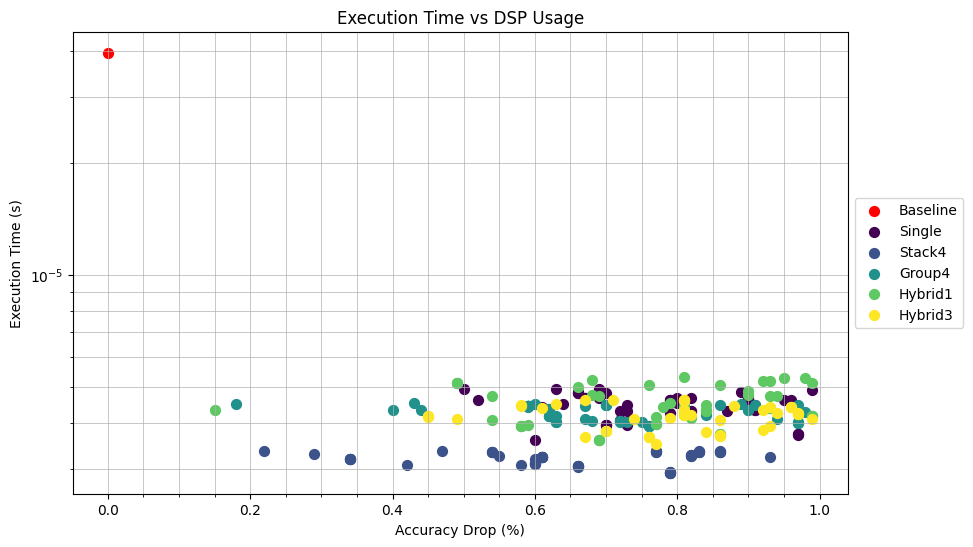

In [68]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(accuracy_baseline*100 - baseline_10GB_min['Accuracy (%)'], baseline_10GB_min['Execution Time (s)'],
            color='red', marker='o', s=50, label='Baseline')

plt.scatter(accuracy_baseline*100 - single_10GB_min_5['Accuracy (%)'], single_10GB_min_5['Execution Time (s)'],
            color=colors[0], marker='o', s=50, label='Single')

plt.scatter(accuracy_baseline*100 - stack4_10GB_min_5['Accuracy (%)'], stack4_10GB_min_5['Execution Time (s)'],
            color=colors[1], marker='o', s=50, label='Stack4')

plt.scatter(accuracy_baseline*100 - group4_10GB_min_5['Accuracy (%)'], group4_10GB_min_5['Execution Time (s)'],
            color=colors[2], marker='o', s=50, label='Group4')
            
plt.scatter(accuracy_baseline*100 - hybrid1_10GB_min_5['Accuracy (%)'], hybrid1_10GB_min_5['Execution Time (s)'],
            color=colors[3], marker='o', s=50, label='Hybrid1')

plt.scatter(accuracy_baseline*100 - hybrid3_10GB_min_5['Accuracy (%)'], hybrid3_10GB_min_5['Execution Time (s)'],
            color=colors[4], marker='o', s=50, label='Hybrid3')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('Accuracy Drop (%)')
plt.ylabel('Execution Time (s)')
# Setting y-axis to logarithmic scale
plt.yscale('log')

# Setting minor locators for the y-axis
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))

# Setting minor locators for the x-axis
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Automatically determine the number of minor intervals

# Enabling grid for both major and minor ticks
plt.grid(True, which="both", linestyle='-', linewidth=0.5, axis='both')  # Enable grid on both axes

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [771]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
single_10_1825 = update_results(single_10GB_dsp,200,10,10)
stack4_10_1825 = update_results(stack4_10GB_dsp,200,10,10)
group4_10_1825 = update_results(group4_10GB_dsp,200,10,10)
hybrid1_10_1825 = update_results(hybrid1_10GB_dsp,200,10,10)
hybrid3_10_1825 = update_results(hybrid3_10GB_dsp,200,10,10)


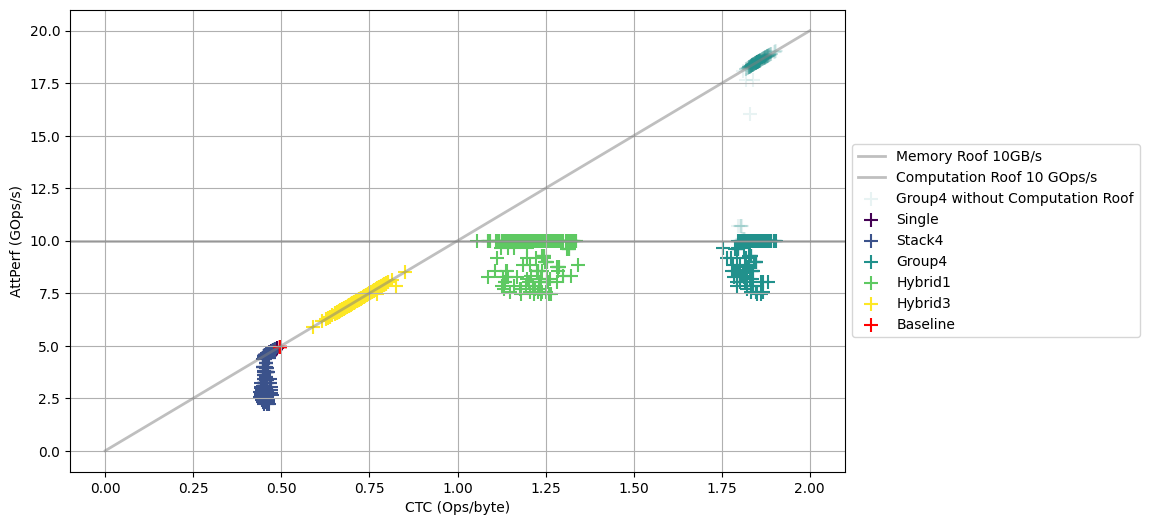

In [775]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.5, linewidth=2)
plt.axhline(y=10, color='gray',alpha=0.5,label='Computation Roof 10 GOps/s', linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4 without Computation Roof', alpha=0.1)

plt.scatter(single_10_1825['CTC (Ops/byte)'], single_10_1825['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_10_1825['CTC (Ops/byte)'], stack4_10_1825['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_10_1825['CTC (Ops/byte)'], group4_10_1825['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_10_1825['CTC (Ops/byte)'], hybrid1_10_1825['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_10_1825['CTC (Ops/byte)'], hybrid3_10_1825['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

plt.scatter(baseline_10GB_dsp['CTC (Ops/byte)'], baseline_10GB_dsp['AttPerf (GOps/s)'],
            color='red', marker='+', s=100, label='Baseline')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
# plt.ylim([4,20])
# plt.xlim([0.3,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

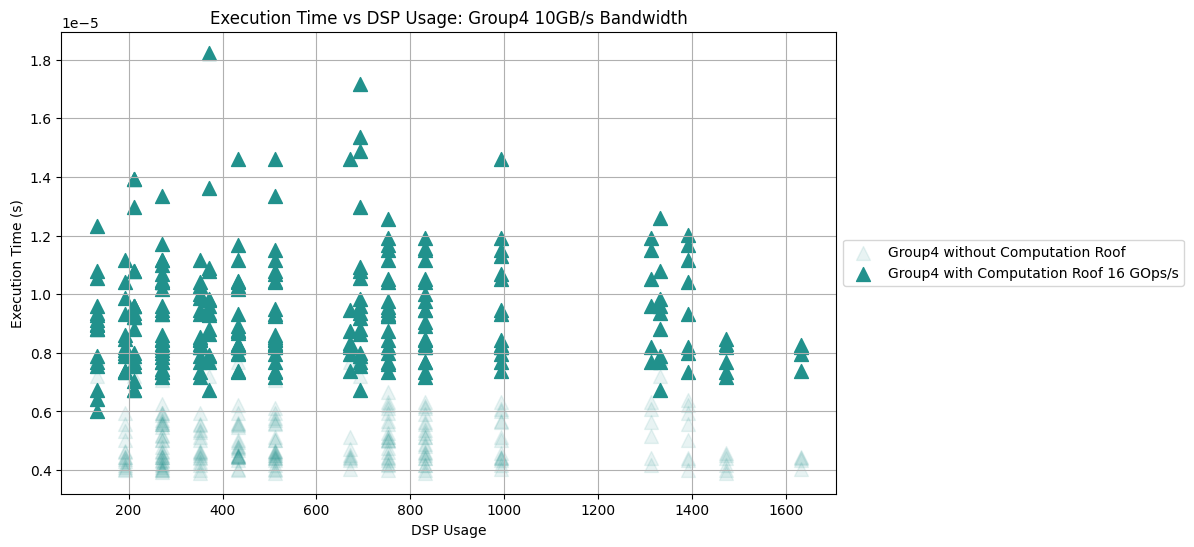

In [776]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))


plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 without Computation Roof ', alpha=0.1)

plt.scatter(group4_10_1825['DSP Usage'], group4_10_1825['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 with Computation Roof 16 GOps/s')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage: Group4 10GB/s Bandwidth')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

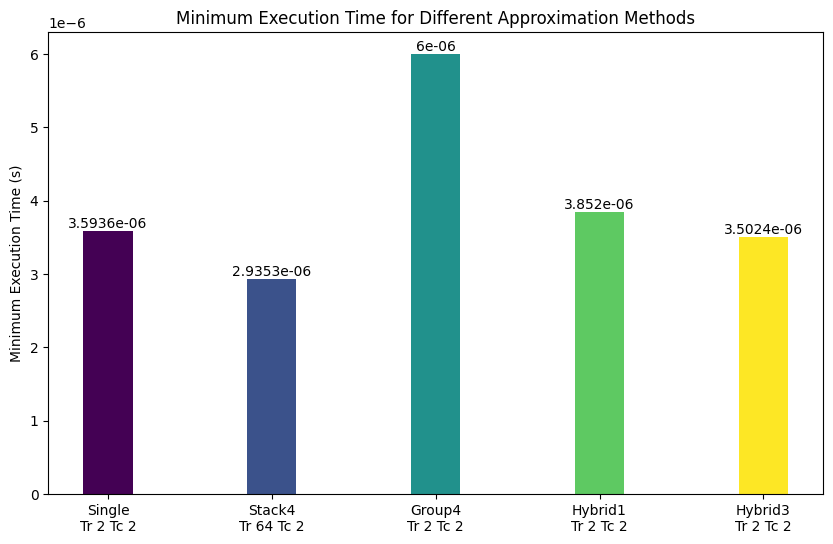

In [777]:
single_10GB_min = single_10_1825[single_10_1825['Execution Time (s)'] == single_10_1825['Execution Time (s)'].min()]
stack4_10GB_min = stack4_10_1825[stack4_10_1825['Execution Time (s)'] == stack4_10_1825['Execution Time (s)'].min()]
group4_10GB_min = group4_10_1825[group4_10_1825['Execution Time (s)'] == group4_10_1825['Execution Time (s)'].min()]
hybrid1_10GB_min = hybrid1_10_1825[hybrid1_10_1825['Execution Time (s)'] == hybrid1_10_1825['Execution Time (s)'].min()]
hybrid3_10GB_min = hybrid3_10_1825[hybrid3_10_1825['Execution Time (s)'] == hybrid3_10_1825['Execution Time (s)'].min()]

# Prepare a summary DataFrame
min_values = {
    'Dataset': [
        f"Single\nTr {int(single_10GB_min['Tr'].iloc[0])} Tc {int(single_10GB_min['Tc'].iloc[0])}",
        f"Stack4\nTr {int(stack4_10GB_min['Tr'].iloc[0])} Tc {int(stack4_10GB_min['Tc'].iloc[0])}",
        f"Group4\nTr {int(group4_10GB_min['Tr'].iloc[0])} Tc {int(group4_10GB_min['Tc'].iloc[0])}",
        f"Hybrid1\nTr {int(hybrid1_10GB_min['Tr'].iloc[0])} Tc {int(hybrid1_10GB_min['Tc'].iloc[0])}",
        f"Hybrid3\nTr {int(hybrid3_10GB_min['Tr'].iloc[0])} Tc {int(hybrid3_10GB_min['Tc'].iloc[0])}"
    ],
    'Min Execution Time (s)': [
        single_10GB_min['Execution Time (s)'].iloc[0],
        stack4_10GB_min['Execution Time (s)'].iloc[0],
        group4_10GB_min['Execution Time (s)'].iloc[0],
        hybrid1_10GB_min['Execution Time (s)'].iloc[0],
        hybrid3_10GB_min['Execution Time (s)'].iloc[0]
    ]
}

df_min_values = pd.DataFrame(min_values)

# Plotting
plt.figure(figsize=(10, 6))

bars = plt.bar(df_min_values['Dataset'], df_min_values['Min Execution Time (s)'], color=colors, width=0.3)

# Adding labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')  # Adjust `round(yval, 2)` if you need different precision

plt.ylabel('Minimum Execution Time (s)')
plt.title('Minimum Execution Time for Different Approximation Methods')
plt.show()

In [778]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
single_5GB = update_results(single_10GB_dsp,200,5,20)
stack4_5GB = update_results(stack4_10GB_dsp,200,5,20)
group4_5GB = update_results(group4_10GB_dsp,200,5,20)
hybrid1_5GB = update_results(hybrid1_10GB_dsp,200,5,20)
hybrid3_5GB = update_results(hybrid3_10GB_dsp,200,5,20)

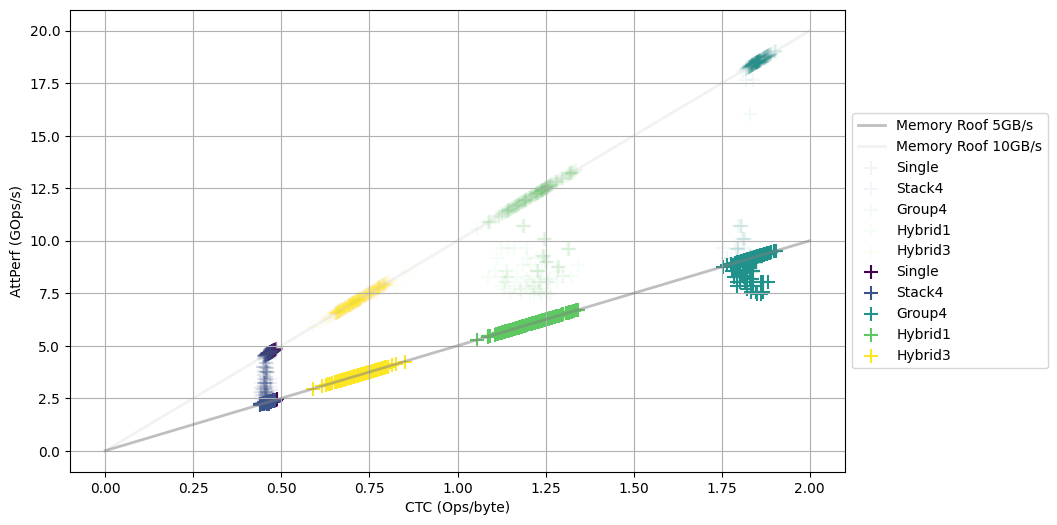

In [780]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 5 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 5GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_5GB['CTC (Ops/byte)'], single_5GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_5GB['CTC (Ops/byte)'], stack4_5GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_5GB['CTC (Ops/byte)'], group4_5GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_5GB['CTC (Ops/byte)'], hybrid1_5GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_5GB['CTC (Ops/byte)'], hybrid3_5GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

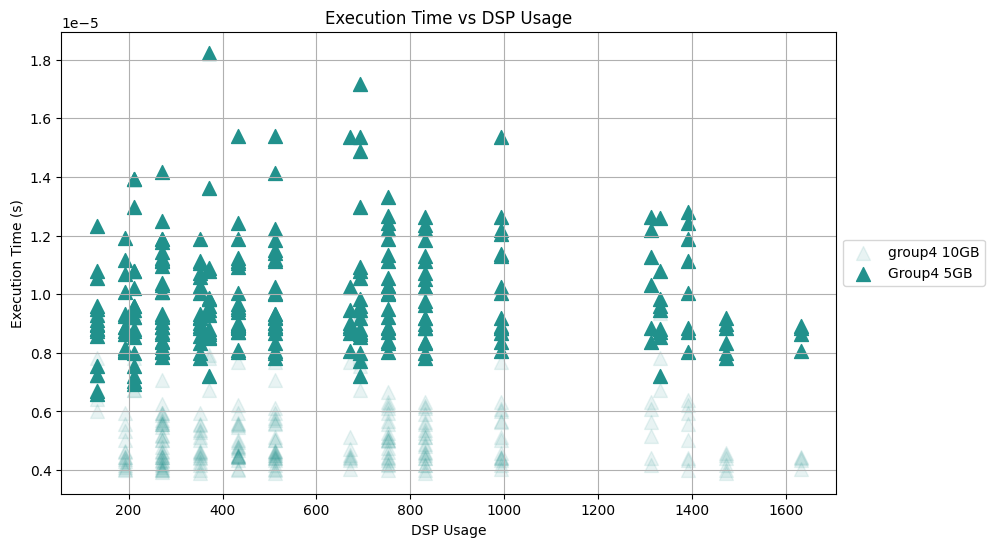

In [781]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='group4 10GB',alpha=0.1)

plt.scatter(group4_5GB['DSP Usage'], group4_5GB['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 5GB')

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

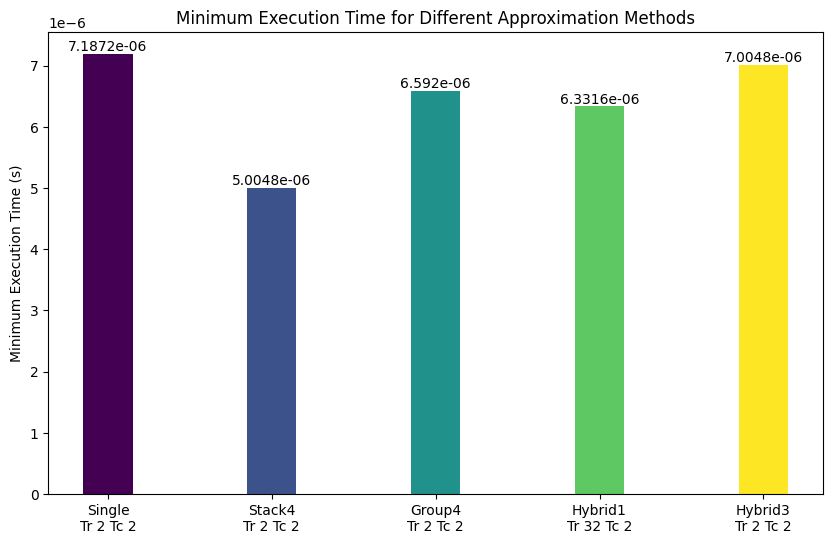

In [782]:
single_5GB_min1 = single_5GB[single_5GB['Execution Time (s)'] == single_5GB['Execution Time (s)'].min()]
stack4_5GB_min1 = stack4_5GB[stack4_5GB['Execution Time (s)'] == stack4_5GB['Execution Time (s)'].min()]
group4_5GB_min1 = group4_5GB[group4_5GB['Execution Time (s)'] == group4_5GB['Execution Time (s)'].min()]
hybrid1_5GB_min1 = hybrid1_5GB[hybrid1_5GB['Execution Time (s)'] == hybrid1_5GB['Execution Time (s)'].min()]
hybrid3_5GB_min1 = hybrid3_5GB[hybrid3_5GB['Execution Time (s)'] == hybrid3_5GB['Execution Time (s)'].min()]

# Prepare a summary DataFrame
min_values = {
    'Dataset': [
        f"Single\nTr {int(single_5GB_min1['Tr'].iloc[0])} Tc {int(single_5GB_min1['Tc'].iloc[0])}",
        f"Stack4\nTr {int(stack4_5GB_min1['Tr'].iloc[0])} Tc {int(stack4_5GB_min1['Tc'].iloc[0])}",
        f"Group4\nTr {int(group4_5GB_min1['Tr'].iloc[0])} Tc {int(group4_5GB_min1['Tc'].iloc[0])}",
        f"Hybrid1\nTr {int(hybrid1_5GB_min1['Tr'].iloc[0])} Tc {int(hybrid1_5GB_min1['Tc'].iloc[0])}",
        f"Hybrid3\nTr {int(hybrid3_5GB_min1['Tr'].iloc[0])} Tc {int(hybrid3_5GB_min1['Tc'].iloc[0])}"
    ],
    'Min Execution Time (s)': [
        single_5GB_min1['Execution Time (s)'].iloc[0],
        stack4_5GB_min1['Execution Time (s)'].iloc[0],
        group4_5GB_min1['Execution Time (s)'].iloc[0],
        hybrid1_5GB_min1['Execution Time (s)'].iloc[0],
        hybrid3_5GB_min1['Execution Time (s)'].iloc[0]
    ]
}

df_min_values = pd.DataFrame(min_values)

# Plotting
plt.figure(figsize=(10, 6))

bars = plt.bar(df_min_values['Dataset'], df_min_values['Min Execution Time (s)'], color=colors, width=0.3)

# Adding labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')  # Adjust `round(yval, 2)` if you need different precision

plt.ylabel('Minimum Execution Time (s)')
plt.title('Minimum Execution Time for Different Approximation Methods')
plt.show()

In [159]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
baseline_20GB = update_results(baseline_10GB_dsp,200,20,50)
single_20GB = update_results(single_10GB_dsp,200,20,50)
stack4_20GB = update_results(stack4_10GB_dsp,200,20,50)
group4_20GB = update_results(group4_10GB_dsp,200,20,50)
hybrid1_20GB = update_results(hybrid1_10GB_dsp,200,20,50)
hybrid3_20GB = update_results(hybrid3_10GB_dsp,200,20,50)

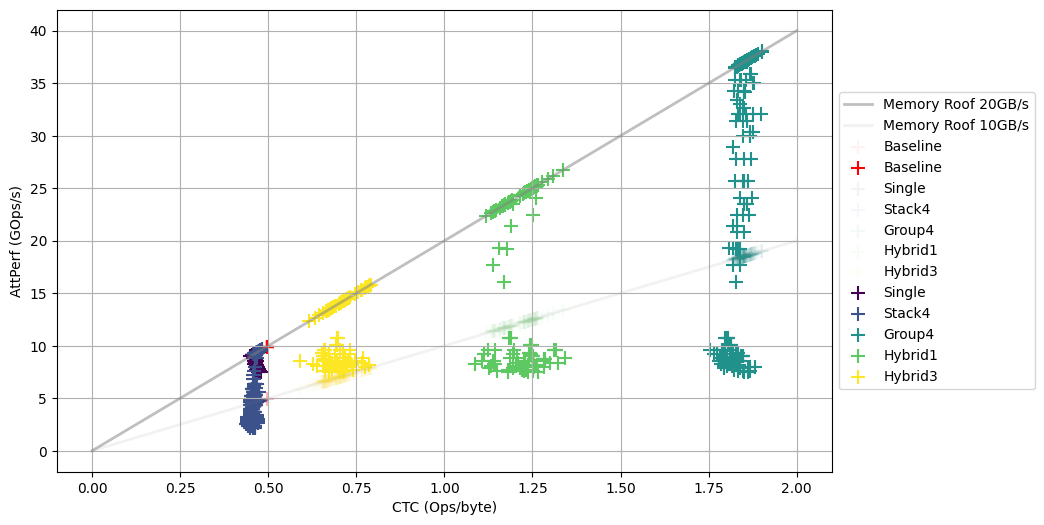

In [160]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 20 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 20GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(baseline_10GB_dsp['CTC (Ops/byte)'], baseline_10GB_dsp['AttPerf (GOps/s)'],
            color='r', marker='+', s=100, label='Baseline', alpha=0.05)

plt.scatter(baseline_20GB['CTC (Ops/byte)'], baseline_20GB['AttPerf (GOps/s)'],
            color='r', marker='+', s=100, label='Baseline')

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_20GB['CTC (Ops/byte)'], single_20GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_20GB['CTC (Ops/byte)'], stack4_20GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_20GB['CTC (Ops/byte)'], group4_20GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_20GB['CTC (Ops/byte)'], hybrid1_20GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_20GB['CTC (Ops/byte)'], hybrid3_20GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
# plt.ylim([2,20])
# plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

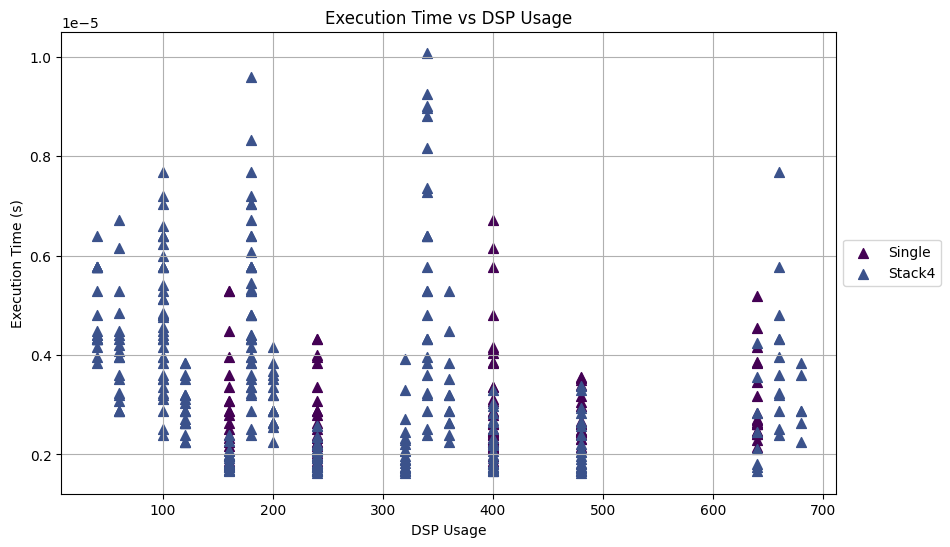

In [170]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_20GB['DSP Usage'], single_20GB['Execution Time (s)'],
            color=colors[0], marker='^', s=50, label='Single')

plt.scatter(stack4_20GB['DSP Usage'], stack4_20GB['Execution Time (s)'],
            color=colors[1], marker='^', s=50, label='Stack4')

# plt.scatter(group4_20GB['DSP Usage'], group4_20GB['Execution Time (s)'],
#             color=colors[2], marker='^', s=50, label='Group4')
            
# plt.scatter(hybrid1_20GB['DSP Usage'], hybrid1_20GB['Execution Time (s)'],
#             color=colors[3], marker='^', s=50, label='Hybrid1')

# plt.scatter(hybrid3_20GB['DSP Usage'], hybrid3_20GB['Execution Time (s)'],
#             color=colors[4], marker='^', s=50, label='Hybrid3')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

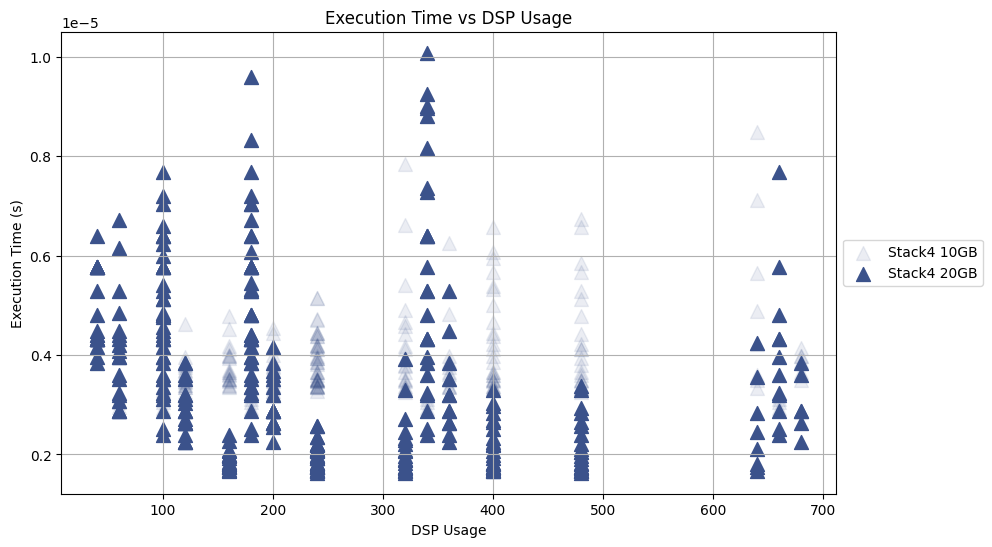

In [161]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 10GB',alpha=0.1)

plt.scatter(stack4_20GB['DSP Usage'], stack4_20GB['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 20GB')

            
# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

In [162]:
baseline_20GB_min = baseline_20GB[baseline_20GB['Execution Time (s)'] == baseline_20GB['Execution Time (s)'].min()].iloc[0]
single_20GB_min = single_20GB[single_20GB['Execution Time (s)'] == single_20GB['Execution Time (s)'].min()]
stack4_20GB_min = stack4_20GB[stack4_20GB['Execution Time (s)'] == stack4_20GB['Execution Time (s)'].min()]
group4_20GB_min = group4_20GB[group4_20GB['Execution Time (s)'] == group4_20GB['Execution Time (s)'].min()]
hybrid1_20GB_min = hybrid1_20GB[hybrid1_20GB['Execution Time (s)'] == hybrid1_20GB['Execution Time (s)'].min()]
hybrid3_20GB_min = hybrid3_20GB[hybrid3_20GB['Execution Time (s)'] == hybrid3_20GB['Execution Time (s)'].min()]


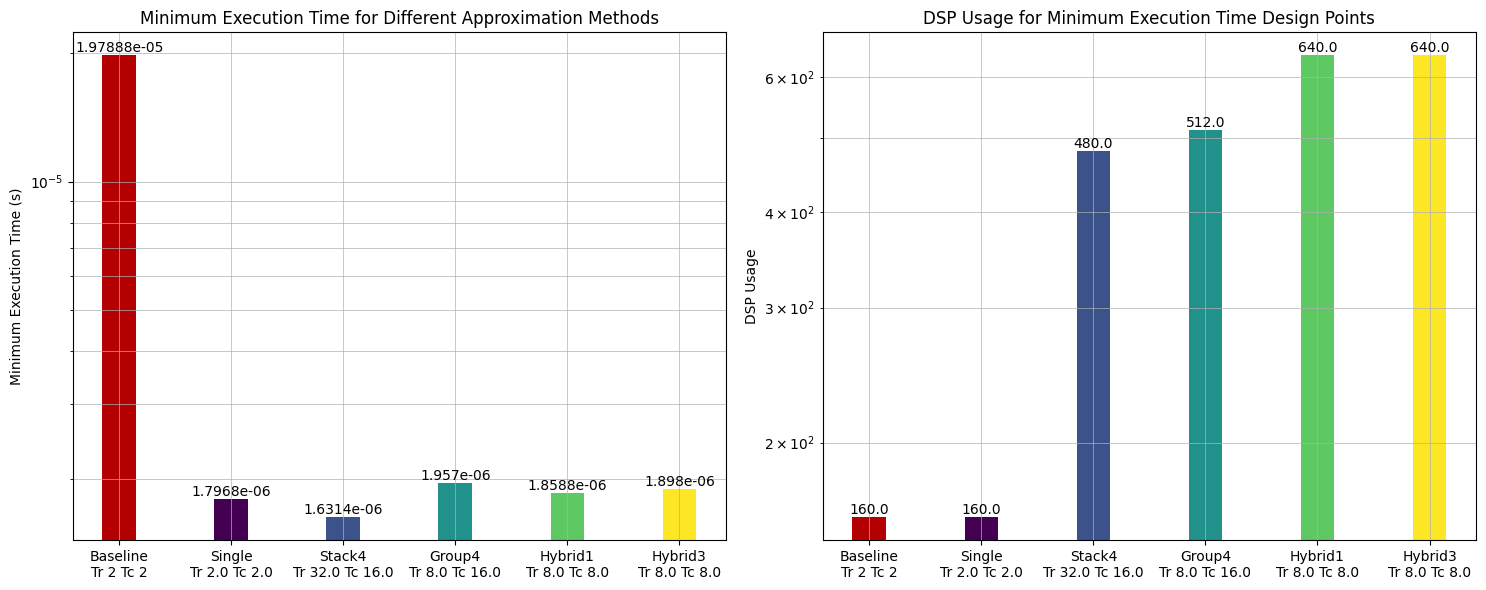

In [163]:
import matplotlib.ticker as ticker

# Prepare the DataFrame for Minimum Execution Time
df_min_values_time = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_20GB_min['Tr']} Tc {baseline_20GB_min['Tc']}",
        f"Single\nTr {single_20GB_min['Tr'].iloc[0]} Tc {single_20GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_20GB_min['Tr'].iloc[0]} Tc {stack4_20GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_20GB_min['Tr'].iloc[0]} Tc {group4_20GB_min['Tc'].iloc[0]}",
        f"Hybrid1\nTr {hybrid1_20GB_min['Tr'].iloc[0]} Tc {hybrid1_20GB_min['Tc'].iloc[0]}",
        f"Hybrid3\nTr {hybrid3_20GB_min['Tr'].iloc[0]} Tc {hybrid3_20GB_min['Tc'].iloc[0]}"
    ],
    'Min Execution Time (s)': [
        baseline_20GB_min['Execution Time (s)'],
        single_20GB_min['Execution Time (s)'].iloc[0],
        stack4_20GB_min['Execution Time (s)'].iloc[0],
        group4_20GB_min['Execution Time (s)'].iloc[0],
        hybrid1_20GB_min['Execution Time (s)'].iloc[0],
        hybrid3_20GB_min['Execution Time (s)'].iloc[0]
    ]
})

# Prepare the DataFrame for DSP Usage
df_min_values_dsp = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_20GB_min['Tr']} Tc {baseline_20GB_min['Tc']}",
        f"Single\nTr {single_20GB_min['Tr'].iloc[0]} Tc {single_20GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_20GB_min['Tr'].iloc[0]} Tc {stack4_20GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_20GB_min['Tr'].iloc[0]} Tc {group4_20GB_min['Tc'].iloc[0]}",
        f"Hybrid1\nTr {hybrid1_20GB_min['Tr'].iloc[0]} Tc {hybrid1_20GB_min['Tc'].iloc[0]}",
        f"Hybrid3\nTr {hybrid3_20GB_min['Tr'].iloc[0]} Tc {hybrid3_20GB_min['Tc'].iloc[0]}"
    ],
    'DSP Usage': [
        baseline_20GB_min['DSP Usage'],
        single_20GB_min['DSP Usage'].iloc[0],
        stack4_20GB_min['DSP Usage'].iloc[0],
        group4_20GB_min['DSP Usage'].iloc[0],
        hybrid1_20GB_min['DSP Usage'].iloc[0],
        hybrid3_20GB_min['DSP Usage'].iloc[0]
    ]
})

# Plotting
plt.figure(figsize=(15, 6))  # Bigger figure to accommodate both subplots

# Subplot for Minimum Execution Time
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
colors = [list([0.7, 0, 0])]  # Red color in RGB
vir_colors = plt.cm.viridis(np.linspace(0, 1, 5))
colors.extend(vir_colors)  # Extend the list with viridis colors

bars_time = plt.bar(df_min_values_time['Dataset'], df_min_values_time['Min Execution Time (s)'], color=colors, width=0.3)
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')

plt.ylabel('Minimum Execution Time (s)')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks
plt.title('Minimum Execution Time for Different Approximation Methods')


# Subplot for DSP Usage
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
bars_dsp = plt.bar(df_min_values_dsp['Dataset'], df_min_values_dsp['DSP Usage'], color=colors, width=0.3)
for bar in bars_dsp:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.ylabel('DSP Usage')
plt.yscale('log')
# Setting the y-axis to have a minor grid with specific locations
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks

plt.title('DSP Usage for Minimum Execution Time Design Points')

plt.tight_layout()  # Adjust layout
plt.show()


# Resource Model
## Xilinx Zynq UltraScale+ MPSoC ZCU104 FPGA


## Synthesis Frequency around 200MHz
## Bandwidth 10GB/s
## LUT 230400
## BRAM 312 37 kilobits per block
## DSP 1728

In [79]:
baseline_10GB_dsp.iloc[[1,2, 4]]

,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
1,2,4,86.14,0,N/A,393216,196096,1536.0,0.495472,25.533333,4.954722,0.00004,320,1573.0,0.000008,4
2,2,8,86.14,0,N/A,393216,196096,768.0,0.495472,51.066667,4.954722,0.00004,640,806.0,0.000004,4
7,4,4,86.14,0,N/A,393216,196096,768.0,0.495472,51.066667,4.954722,0.00004,640,789.0,0.000004,4


In [80]:
single_10GB_dsp.iloc[[1, 50, 112]]

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
1,16,56,2,2,85.23,0.005403,11,52448.0,25344,616,0.460733,8.228571,4.607330,0.000006,160,646,0.000003,24
92,8,14,4,8,85.46,0.005822,13,60840.0,29952,182,0.472429,32.914286,4.724290,0.000006,480,208,0.000001,40
225,8,56,8,2,85.17,0.005911,6,34608.0,16896,336,0.454585,10.057143,4.545846,0.000004,400,353,0.000002,72


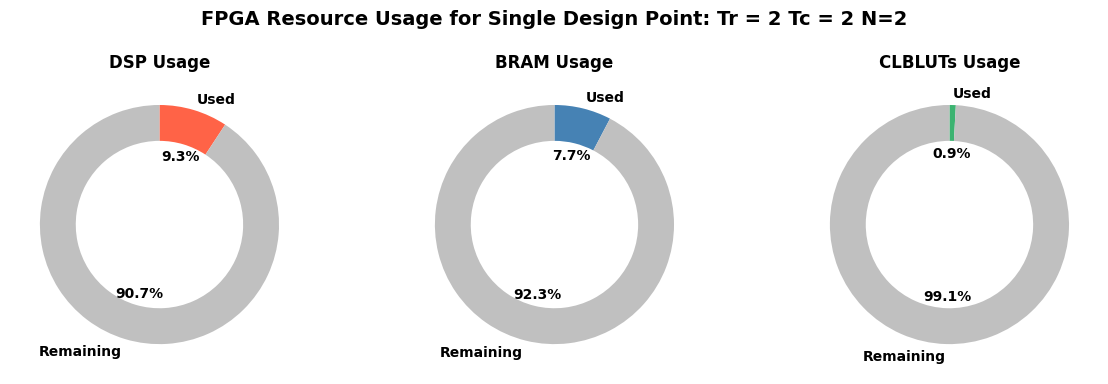

In [158]:
import matplotlib.pyplot as plt

# Define the usage percentages
dsp_usage = single_10GB_dsp.iloc[1]['DSP Usage'] / 1728 * 100
bram_usage = single_10GB_dsp.iloc[1]['BRAM Usage'] / 312 * 100
clbluts_usage = (1740 + 55 * 4) / 230400 * 100

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Define labels and colors
labels = ['Used', 'Remaining']
dsp_colors = ['#FF6347', '#C0C0C0']    # Tomato and Silver
bram_colors = ['#4682B4', '#C0C0C0']   # SteelBlue and Silver
clbluts_colors = ['#3CB371', '#C0C0C0'] # MediumSeaGreen and Silver
remaining = 100

# DSP Usage Donut Plot
axs[0].pie([dsp_usage, remaining - dsp_usage], labels=labels, colors=dsp_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[0].set_title('DSP Usage', fontweight='bold')

# BRAM Usage Donut Plot
axs[1].pie([bram_usage, remaining - bram_usage], labels=labels, colors=bram_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[1].set_title('BRAM Usage', fontweight='bold')

# CLBLUTs Usage Donut Plot
axs[2].pie([clbluts_usage, remaining - clbluts_usage], labels=labels, colors=clbluts_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[2].set_title('CLBLUTs Usage', fontweight='bold')

# Add a title for the entire plot
fig.suptitle('FPGA Resource Usage for Single Design Point: Tr = 2 Tc = 2 N=2', fontweight='bold',fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()


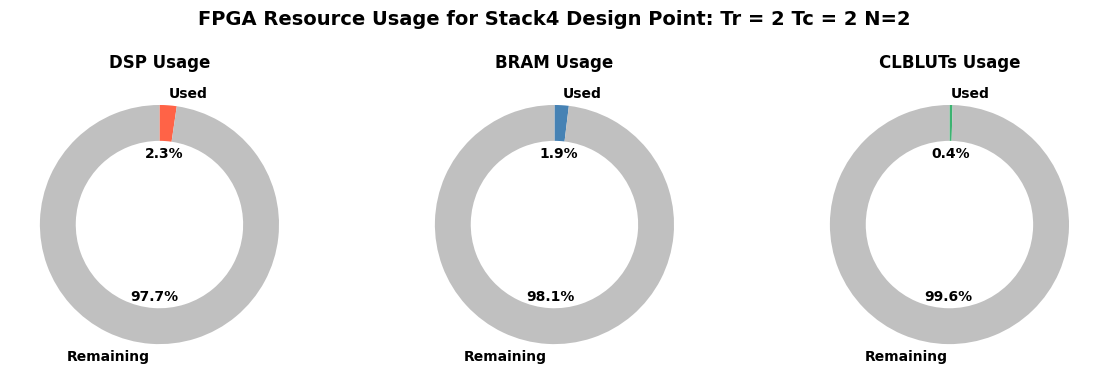

In [157]:
# Define the usage percentages
dsp_usage = stack4_10GB_dsp.iloc[1]['DSP Usage'] / 1728 * 100
bram_usage = stack4_10GB_dsp.iloc[1]['BRAM Usage'] / 312 * 100
clbluts_usage = (893 + 55) / 230400 * 100

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Define labels and colors
labels = ['Used', 'Remaining']
dsp_colors = ['#FF6347', '#C0C0C0']    # Tomato and Silver
bram_colors = ['#4682B4', '#C0C0C0']   # SteelBlue and Silver
clbluts_colors = ['#3CB371', '#C0C0C0'] # MediumSeaGreen and Silver
remaining = 100

# DSP Usage Donut Plot
axs[0].pie([dsp_usage, remaining - dsp_usage], labels=labels, colors=dsp_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[0].set_title('DSP Usage', fontweight='bold')

# BRAM Usage Donut Plot
axs[1].pie([bram_usage, remaining - bram_usage], labels=labels, colors=bram_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[1].set_title('BRAM Usage', fontweight='bold')

# CLBLUTs Usage Donut Plot
axs[2].pie([clbluts_usage, remaining - clbluts_usage], labels=labels, colors=clbluts_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[2].set_title('CLBLUTs Usage', fontweight='bold')

# Add a title for the entire plot
fig.suptitle('FPGA Resource Usage for Stack4 Design Point: Tr = 2 Tc = 2 N=2', fontweight='bold',fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

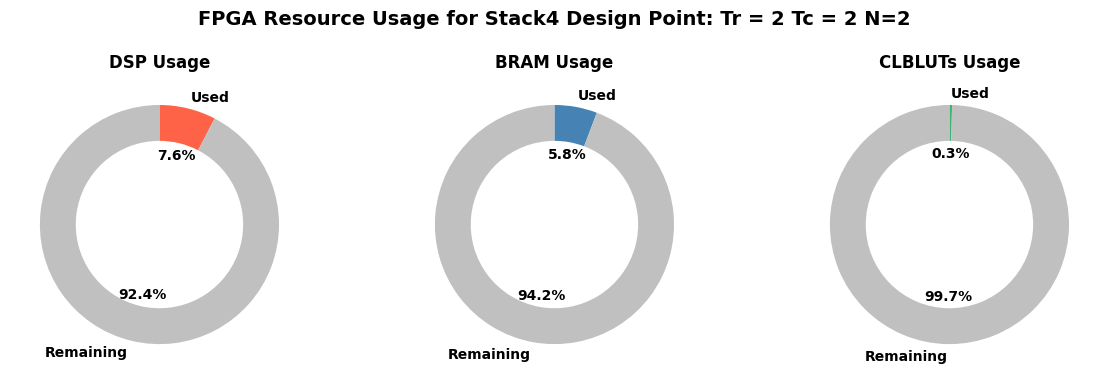

In [156]:
# Define the usage percentages
dsp_usage = group4_10GB_dsp.iloc[1]['DSP Usage'] / 1728 * 100
bram_usage = group4_10GB_dsp.iloc[1]['BRAM Usage'] / 312 * 100
clbluts_usage = (744 + 57) / 230400 * 100

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Define labels and colors
labels = ['Used', 'Remaining']
dsp_colors = ['#FF6347', '#C0C0C0']    # Tomato and Silver
bram_colors = ['#4682B4', '#C0C0C0']   # SteelBlue and Silver
clbluts_colors = ['#3CB371', '#C0C0C0'] # MediumSeaGreen and Silver
remaining = 100

# DSP Usage Donut Plot
axs[0].pie([dsp_usage, remaining - dsp_usage], labels=labels, colors=dsp_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[0].set_title('DSP Usage', fontweight='bold')

# BRAM Usage Donut Plot
axs[1].pie([bram_usage, remaining - bram_usage], labels=labels, colors=bram_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[1].set_title('BRAM Usage', fontweight='bold')

# CLBLUTs Usage Donut Plot
axs[2].pie([clbluts_usage, remaining - clbluts_usage], labels=labels, colors=clbluts_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[2].set_title('CLBLUTs Usage', fontweight='bold')

# Add a title for the entire plot
fig.suptitle('FPGA Resource Usage for Stack4 Design Point: Tr = 2 Tc = 2 N=2', fontweight='bold',fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Define the usage percentages
dsp_usage = single_10GB_dsp.iloc[]['DSP Usage'] / 1728 * 100
bram_usage = single_10GB_dsp.iloc[1]['BRAM Usage'] / 312 * 100
clbluts_usage = (1740 + 55 * 4) / 230400 * 100

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

# Define labels and colors
labels = ['Used', 'Remaining']
dsp_colors = ['#FF6347', '#C0C0C0']    # Tomato and Silver
bram_colors = ['#4682B4', '#C0C0C0']   # SteelBlue and Silver
clbluts_colors = ['#3CB371', '#C0C0C0'] # MediumSeaGreen and Silver
remaining = 100

# DSP Usage Donut Plot
axs[0].pie([dsp_usage, remaining - dsp_usage], labels=labels, colors=dsp_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[0].set_title('DSP Usage', fontweight='bold')

# BRAM Usage Donut Plot
axs[1].pie([bram_usage, remaining - bram_usage], labels=labels, colors=bram_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[1].set_title('BRAM Usage', fontweight='bold')

# CLBLUTs Usage Donut Plot
axs[2].pie([clbluts_usage, remaining - clbluts_usage], labels=labels, colors=clbluts_colors,
           autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3), textprops=dict(fontweight='bold'))
axs[2].set_title('CLBLUTs Usage', fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

In [81]:
stack4_10GB_dsp.iloc[[1, 50, 112,187]]

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
1,16,56,2,2,85.94,0.005935,13,25792.0,12480,832,0.440181,3.000000,3.000000,0.000004,40,856,0.000004,6
51,24,5,2,32,85.34,0.005917,9,25717.5,12672,864,0.448130,2.933333,2.933333,0.000004,340,813,0.000004,6
121,12,16,4,8,85.92,0.005895,12,31080.0,15360,576,0.456599,5.333333,4.565993,0.000003,120,573,0.000003,10
201,6,88,8,2,85.55,0.005712,11,32824.0,16192,968,0.457608,3.345455,3.345455,0.000005,100,988,0.000005,18


In [82]:
group4_10GB_dsp.iloc[[0,11,12]]

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,BRAM Usage,Simulated Ncycles,Simulated Execution Time (s)
0,16,48,2,2,85.15,0.005647,38,41344.0,78128,1824,1.779519,8.566667,8.566667,0.000009,132,18,1881,0.000009
28,24,48,2,2,85.60,0.005949,25,30400.0,57800,1200,1.753641,9.633333,9.633333,0.000006,132,18,1252,0.000006
29,24,56,2,2,85.25,0.005907,23,30912.0,59064,1288,1.764579,9.171429,9.171429,0.000006,132,18,1338,0.000007


In [83]:
hybrid1_10GB_dsp.iloc[[0,42,108]]

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
0,16,48,2,2,85.16,0.005536,25,42512.0,51400,1200,1.140398,8.566667,8.566667,0.000006,160,1244,0.000006,24
85,8,56,4,2,85.34,0.005440,26,52752.0,60112,1456,1.086780,8.257143,8.257143,0.000007,240,1493,0.000007,40
224,8,48,8,2,85.45,0.005940,15,29865.0,38520,720,1.187972,10.700000,10.700000,0.000004,400,746,0.000004,72


In [421]:
baseline_10GB_min = baseline_10GB_dsp.nsmallest(50, 'Execution Time (s)')
baseline_10GB_min 

,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
0,2,2,86.14,0,N/A,393216,196096,3072.0,0.495472,12.766667,4.954722,0.00004,160,3108.0,0.000016,4


In [423]:
single_10GB_min = single_10GB_dsp.nsmallest(5, 'Execution Time (s)')
single_10GB_min 

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
28,24,48,2,2,85.54,0.005948,7,33376.0,16128,336,0.448798,9.600000,4.487979,0.000004,160,370,0.000002,24
393,1,56,64,2,85.17,0.005911,6,34566.0,16896,336,0.455099,10.057143,4.550989,0.000004,2640,346,0.000002,520
365,2,56,32,2,85.17,0.005911,6,34572.0,16896,336,0.455025,10.057143,4.550253,0.000004,1360,347,0.000002,264
309,4,56,16,2,85.17,0.005911,6,34584.0,16896,336,0.454878,10.057143,4.548783,0.000004,720,349,0.000002,136
225,8,56,8,2,85.17,0.005911,6,34608.0,16896,336,0.454585,10.057143,4.545846,0.000004,400,353,0.000002,72


In [424]:
stack4_10GB_min = stack4_10GB_dsp.nsmallest(5, 'Execution Time (s)')
stack4_10GB_min 

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
309,4,56,16,2,85.35,0.005859,9,26820.0,13248,504,0.450919,5.257143,4.509190,0.000003,180,520,0.000003,34
225,8,56,8,2,85.35,0.005859,9,26856.0,13248,504,0.450367,5.257143,4.503671,0.000003,100,524,0.000003,18
141,16,56,4,2,85.35,0.005859,9,26928.0,13248,576,0.449267,4.600000,4.492675,0.000003,60,596,0.000003,10
310,4,64,16,2,85.48,0.005739,9,27972.0,13824,576,0.452771,4.800000,4.527709,0.000003,180,592,0.000003,34
226,8,64,8,2,85.48,0.005739,9,28008.0,13824,576,0.452238,4.800000,4.522376,0.000003,100,596,0.000003,18


In [410]:
group4_10GB_min

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,BRAM Usage,Simulated Ncycles,Simulated Execution Time (s)
39,24,20,2,8,85.39,0.005855,22,37620.0,73392,528,1.82658,27.8,18.265804,0.000004,192,18,575,0.000003


In [411]:
hybrid1_10GB_min

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
56,32,48,2,2,85.45,0.00594,15,30000.0,38520,720,1.183047,10.7,10.7,0.000004,160,770,0.000004,24


In [412]:
hybrid3_10GB_min

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
29,24,56,2,2,85.37,0.005875,10,32464.0,25680,560,0.733212,9.171429,7.332115,0.000004,160,597,0.000003,24


In [426]:
# Select the 1st, 15th, and 20th entry for plotting
selected_baseline = baseline_10GB_dsp.iloc[[1,2, 4]]
# selected_single = single_10GB_dsp.iloc[[1, 50, 112]]
# # selected_stack4 = stack4_10GB_dsp.iloc[[0,61,160]]
# selected_hybrid3 = hybrid1_10GB_dsp.iloc[[42,108]]

# selected_stack4 = stack4_10GB_dsp.iloc[[1, 50, 112,187]]
# selected_group4 = group4_10GB_dsp.iloc[[0,11,12]]
# selected_hybrid1 = hybrid1_10GB_dsp.iloc[[0,42]]

IndexError: positional indexers are out-of-bounds

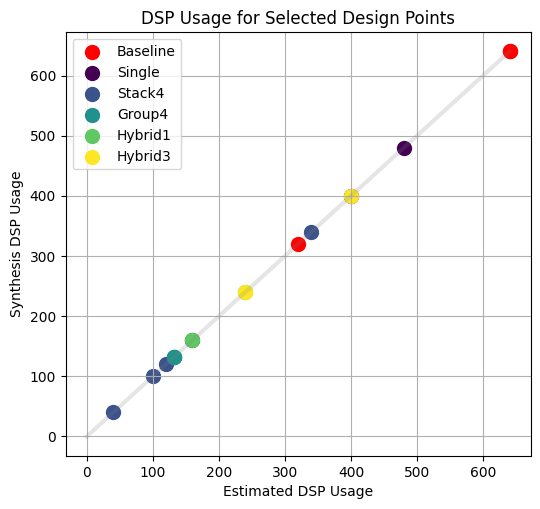

In [199]:
import pandas as pd
import matplotlib.pyplot as plt

colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Select the 1st, 15th, and 20th entry for plotting
selected_baseline = baseline_10GB_dsp.iloc[[1,2, 4]]
selected_single = single_10GB_dsp.iloc[[1, 50, 112]]
# selected_stack4 = stack4_10GB_dsp.iloc[[0,61,160]]
selected_hybrid3 = hybrid1_10GB_dsp.iloc[[42,108]]

selected_stack4 = stack4_10GB_dsp.iloc[[1, 50, 112,187]]
selected_group4 = group4_10GB_dsp.iloc[[0,11,12]]
selected_hybrid1 = hybrid1_10GB_dsp.iloc[[0,42]]

# Plotting DSP usage against itself for the selected entries
plt.figure(figsize=(6,5.5))

# Draw a grey light line y=x
plt.plot([0, max(selected_hybrid1['DSP Usage'].max(), selected_single['DSP Usage'].max(), selected_baseline['DSP Usage'].max(),
                 selected_stack4['DSP Usage'].max(), selected_group4['DSP Usage'].max())],
         [0, max(selected_hybrid1['DSP Usage'].max(), selected_single['DSP Usage'].max(), selected_baseline['DSP Usage'].max(),
                 selected_stack4['DSP Usage'].max(), selected_group4['DSP Usage'].max())],
         color='grey', linestyle='-', linewidth=3,alpha=0.2)

plt.scatter(selected_baseline['DSP Usage'], selected_baseline['DSP Usage'], label='Baseline',color='r', marker='o',s=100)
plt.scatter(selected_single['DSP Usage'], selected_single['DSP Usage'], label='Single',color=colors[0], marker='o',s=100)
plt.scatter(selected_stack4['DSP Usage'], selected_stack4['DSP Usage'], label='Stack4',color=colors[1], marker='o',s=100)
plt.scatter(selected_group4['DSP Usage'], selected_group4['DSP Usage'], label='Group4',color=colors[2], marker='o',s=100)
plt.scatter(selected_hybrid1['DSP Usage'], selected_hybrid1['DSP Usage'], label='Hybrid1',color=colors[3], marker='o',s=100)
plt.scatter(selected_hybrid3['DSP Usage'], selected_hybrid3['DSP Usage'], label='Hybrid3',color=colors[4], marker='o',s=100)
plt.xlabel('Estimated DSP Usage')
plt.ylabel('Synthesis DSP Usage')
plt.title('DSP Usage for Selected Design Points')
plt.legend()
plt.grid(True)
plt.show()

In [455]:
single_10GB_dsp[40:60]

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage,Simulated Ncycles,Simulated Execution Time (s),BRAM Usage
40,24,22,2,8,85.19,0.005779,6,43536.0,21504,144,0.466505,29.866667,4.665047,0.000005,400,177,8.850000e-07,80
41,24,24,2,8,85.50,0.005395,7,54376.0,26880,168,0.472109,32.000000,4.721090,0.000006,400,204,1.020000e-06,80
42,24,6,2,16,85.61,0.005887,10,46840.0,23040,240,0.466397,19.200000,4.663968,0.000005,720,262,1.310000e-06,144
43,24,7,2,16,85.23,0.005839,9,46764.0,23040,216,0.467115,21.333333,4.671154,0.000005,720,238,1.190000e-06,144
44,24,8,2,16,85.25,0.005804,8,45664.0,22528,192,0.467153,23.466667,4.671533,0.000005,720,214,1.070000e-06,144
45,24,9,2,16,85.92,0.005828,7,43540.0,21504,168,0.466464,25.600000,4.664642,0.000005,720,190,9.500000e-07,144
46,24,10,2,16,85.21,0.005937,6,40392.0,19968,144,0.464891,27.733333,4.648910,0.000004,720,166,8.300000e-07,144
47,24,11,2,16,85.50,0.005505,7,50708.0,25088,168,0.470977,29.866667,4.709769,0.000005,720,192,9.600000e-07,144
48,24,12,2,16,85.50,0.005395,7,54292.0,26880,168,0.472807,32.000000,4.728066,0.000006,720,193,9.650000e-07,144
49,24,3,2,32,85.41,0.005971,10,46780.0,23040,240,0.466964,19.200000,4.669639,0.000005,1360,260,1.300000e-06,272


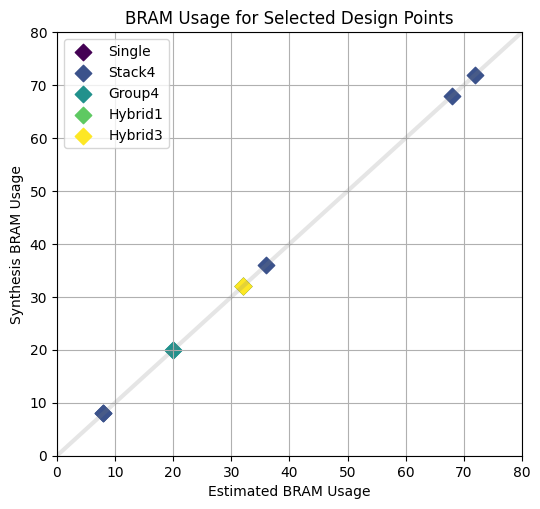

In [456]:
import pandas as pd
import matplotlib.pyplot as plt

# Select the 1st, 15th, and 20th entry for plotting
selected_baseline = baseline_10GB_dsp.iloc[[1,2, 4]]
selected_single = single_10GB_dsp.iloc[[1, 50]]
# selected_stack4 = stack4_10GB_dsp.iloc[[0,61,160]]
selected_hybrid3 = hybrid1_10GB_dsp.iloc[[0,42]]

selected_stack4 = stack4_10GB_dsp.iloc[[1, 9, 15, 50, 112,187]]
selected_group4 = group4_10GB_dsp.iloc[[0,11,12]]
selected_hybrid1 = hybrid1_10GB_dsp.iloc[[0,42]]

# Plotting DSP usage against itself for the selected entries
plt.figure(figsize=(6,5.5))

# Draw a grey light line y=x
plt.plot([0, max(selected_hybrid1['BRAM Usage'].max(), selected_single['BRAM Usage'].max(), selected_baseline['BRAM Usage'].max(),
                 selected_stack4['BRAM Usage'].max(), selected_group4['BRAM Usage'].max())],
         [0, max(selected_hybrid1['BRAM Usage'].max(), selected_single['BRAM Usage'].max(), selected_baseline['BRAM Usage'].max(),
                 selected_stack4['BRAM Usage'].max(), selected_group4['BRAM Usage'].max())],
         color='grey', linestyle='-', linewidth=3,alpha=0.2)

# plt.scatter(selected_baseline['BRAM Usage'], selected_baseline['BRAM Usage'], label='Baseline',color='r', marker='D',s=70)
plt.scatter(selected_single['BRAM Usage'], selected_single['BRAM Usage'], label='Single',color=colors[0], marker='D',s=70)
plt.scatter(selected_stack4['BRAM Usage'], selected_stack4['BRAM Usage'], label='Stack4',color=colors[1], marker='D',s=70)
plt.scatter(selected_group4['BRAM Usage'], selected_group4['BRAM Usage'], label='Group4',color=colors[2], marker='D',s=70)
plt.scatter(selected_hybrid1['BRAM Usage'], selected_hybrid1['BRAM Usage'], label='Hybrid1',color=colors[3], marker='D',s=70)
plt.scatter(selected_hybrid3['BRAM Usage'], selected_hybrid3['BRAM Usage'], label='Hybrid3',color=colors[4], marker='D',s=70)
plt.xlabel('Estimated BRAM Usage')
plt.ylabel('Synthesis BRAM Usage')
plt.title('BRAM Usage for Selected Design Points')
plt.legend()
plt.xlim([0,80])
plt.ylim([0,80])
plt.grid(True)
plt.show()

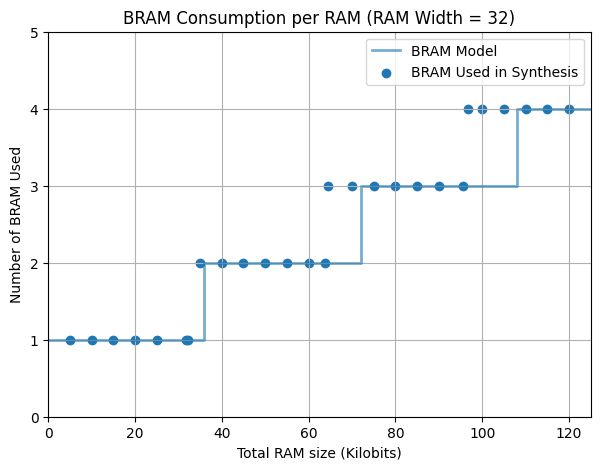

In [221]:
import matplotlib.pyplot as plt
import numpy as np

# Define the step points
x1 = [0, 36, 72, 108,144,180]
y1 = [1, 2, 3, 4, 5,6]

xx1 = [ 5, 10, 15, 20, 25, 31.875, 32.185,35,40,45,50,55,60,63.75,64.375,70,75,80,85,90,95.65,96.65,100,105,110,115,120]
yy1 = [ 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,2,2,3, 3, 3, 3,3,3,3,4,4,4,4,4,4]
fig, ax = plt.subplots(figsize=(7, 5))  # Set the figure size

# Create the step plot
plt.step(x1, y1, where='post',alpha=0.6, label='BRAM Model', linewidth=2)
plt.scatter(xx1, yy1, marker='o',label='BRAM Used in Synthesis')
# Adding titles and labels
plt.title('BRAM Consumption per RAM (RAM Width = 32)')
plt.xlabel('Total RAM size (Kilobits)')
plt.ylabel('Number of BRAM Used')
plt.ylim([0,5])
plt.xlim([0,125])
# Show the plot
plt.grid(True)
plt.legend()
plt.show()


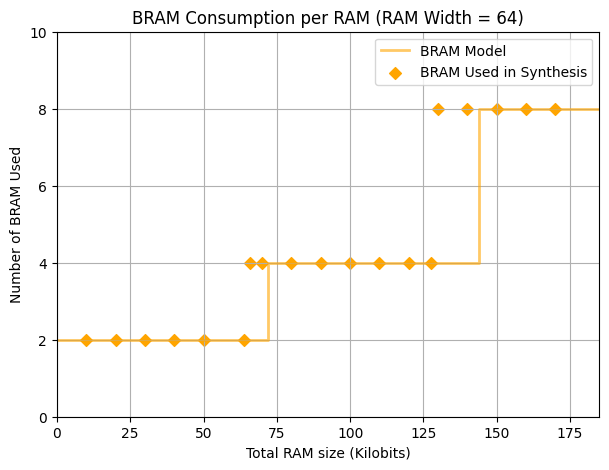

In [215]:
x2 = [0, 72, 144, 216]
y2 = [2, 4, 8,16]

xx2 = [10, 20, 30, 40, 50, 63.75, 65.75, 70,80,90,100,110,120,127.5,130,140,150,160,170]
yy2 = [2, 2, 2, 2, 2, 2, 4,4,4,4,4,4,4,4,8,8,8,8,8]
plt.figure(figsize=(7, 5))
# Create the step plot
plt.step(x2, y2, where='post',alpha=0.6, label='BRAM Model',color='orange', linewidth=2)
plt.scatter(xx2, yy2, marker='D',label='BRAM Used in Synthesis',color='orange')

# Adding titles and labels
plt.title('BRAM Consumption per RAM (RAM Width = 64)')
plt.xlabel('Total RAM size (Kilobits)')
plt.ylabel('Number of BRAM Used')

# Set the limits for better visualization
plt.xlim(0, 185)
plt.ylim(0, 10)

plt.legend()

# Show the plot
plt.grid(True)
plt.show()

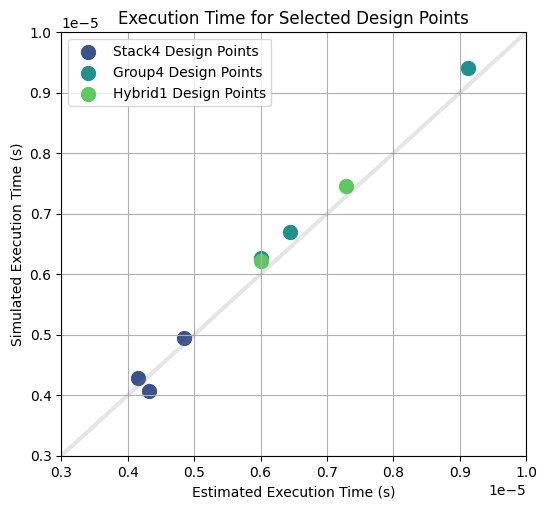

In [222]:
import pandas as pd
import matplotlib.pyplot as plt

# Select the 1st, 15th, and 20th entry for plotting
selected_stack4 = stack4_10GB_dsp.iloc[[1, 50, 112,187]]
selected_group4 = group4_10GB_dsp.iloc[[0,11,12]]
selected_hybrid1 = hybrid1_10GB_dsp.iloc[[0,42,88]]

# Plotting DSP usage against itself for the selected entries
plt.figure(figsize=(6, 5.5))

# Draw a grey light line y=x
plt.plot([0, max(selected_stack4['Execution Time (s)'].max(), selected_group4['Execution Time (s)'].max(), 
                selected_group4['Execution Time (s)'].max(), selected_hybrid1['Execution Time (s)'].max())],
         [0, max(selected_stack4['Execution Time (s)'].max(), selected_group4['Execution Time (s)'].max(), 
                selected_group4['Execution Time (s)'].max(), selected_hybrid1['Execution Time (s)'].max())],
         color='grey', linestyle='-', linewidth=3,alpha=0.2)

# plt.scatter(selected_baseline['DSP Usage'], selected_baseline['DSP Usage'], label='Baseline',color='r', marker='o',s=100)
# plt.scatter(selected_single['DSP Usage'], selected_single['Simulated Execution Time(s)'], label='Single',color=colors[0], marker='o',s=100)
plt.scatter(selected_stack4['Execution Time (s)'], selected_stack4['Simulated Execution Time (s)'], label='Stack4 Design Points',color=colors[1], marker='o',s=100)
plt.scatter(selected_group4['Execution Time (s)'], selected_group4['Simulated Execution Time (s)'], label='Group4 Design Points',color=colors[2], marker='o',s=100)
plt.scatter(selected_hybrid1['Execution Time (s)'], selected_hybrid1['Simulated Execution Time (s)'], label='Hybrid1 Design Points',color=colors[3], marker='o',s=100)

plt.xlabel('Estimated Execution Time (s)')
plt.ylabel('Simulated Execution Time (s)')
plt.title('Execution Time for Selected Design Points')
plt.ylim([0.000003,0.00001])
plt.xlim([0.000003,0.00001])
plt.legend()
plt.grid(True)
plt.show()